In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple, Dict
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from sklearn.model_selection import KFold
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split

from going_modular import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 

In [3]:
dfs = pd.read_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/Results/combined_other_datasets_for_modeling.csv')
dfs.columns

print(f"{dfs['Study_id'].value_counts().to_dict()}\n")

print(f"{dfs['Expt'].value_counts().to_dict()}")


{'301': 959, 'miro': 220, 'lica': 176, '302': 168, '216': 155}

{'riluzole': 1282, 'mirocals': 220, 'licals': 176}


In [4]:
miro = dfs[dfs['Expt'] == 'mirocals']

print(f"{miro['Study_id'].value_counts().to_dict()}\n")
miro = miro.drop(columns=['Study_id'])
print(miro.info())
miro.head(3)

{'miro': 220}

<class 'pandas.core.frame.DataFrame'>
Index: 220 entries, 176 to 395
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        220 non-null    object 
 1   Event             220 non-null    float64
 2   Vital_capacity    220 non-null    float64
 3   Sex               220 non-null    object 
 4   Onset_site        220 non-null    object 
 5   Study_Arm         220 non-null    object 
 6   European          220 non-null    int64  
 7   Age               220 non-null    float64
 8   Diagnostic_Delay  220 non-null    float64
 9   Disease_Duration  220 non-null    float64
 10  TRICALS           220 non-null    float64
 11  Expt              220 non-null    object 
dtypes: float64(6), int64(1), object(5)
memory usage: 22.3+ KB
None


,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt
176,1-62478,1.0,99.0,F,Limb,Placebo,1,70.927,15.108,29.174444,-4.550056,mirocals
177,1-62479,1.0,81.0,F,Bulbar,IL2,1,65.391,15.600,24.144657,-2.933660,mirocals
178,1-62480,0.0,96.0,M,Limb,IL2,1,57.024,8.904,31.308967,-5.212384,mirocals


In [5]:
lical = dfs[dfs['Expt'] == 'licals']

print(f"{lical['Study_id'].value_counts().to_dict()}\n")
lical = lical.drop(columns=['Study_id'])
print(lical.info())
lical.head(3)

{'lica': 176}

<class 'pandas.core.frame.DataFrame'>
Index: 176 entries, 0 to 175
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        176 non-null    object 
 1   Event             176 non-null    float64
 2   Vital_capacity    176 non-null    float64
 3   Sex               176 non-null    object 
 4   Onset_site        176 non-null    object 
 5   Study_Arm         176 non-null    object 
 6   European          176 non-null    int64  
 7   Age               176 non-null    float64
 8   Diagnostic_Delay  176 non-null    float64
 9   Disease_Duration  176 non-null    float64
 10  TRICALS           176 non-null    float64
 11  Expt              176 non-null    object 
dtypes: float64(6), int64(1), object(5)
memory usage: 17.9+ KB
None


,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,licals
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,licals
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,licals


In [6]:
miroli = dfs[dfs['Expt'] != 'riluzole']

print(f"{miroli['Study_id'].value_counts().to_dict()}\n")
miroli = miroli.drop(columns=['Study_id'])
print(miroli.info())
miroli.head(3)

{'miro': 220, 'lica': 176}

<class 'pandas.core.frame.DataFrame'>
Index: 396 entries, 0 to 395
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        396 non-null    object 
 1   Event             396 non-null    float64
 2   Vital_capacity    396 non-null    float64
 3   Sex               396 non-null    object 
 4   Onset_site        396 non-null    object 
 5   Study_Arm         396 non-null    object 
 6   European          396 non-null    int64  
 7   Age               396 non-null    float64
 8   Diagnostic_Delay  396 non-null    float64
 9   Disease_Duration  396 non-null    float64
 10  TRICALS           396 non-null    float64
 11  Expt              396 non-null    object 
dtypes: float64(6), int64(1), object(5)
memory usage: 40.2+ KB
None


,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,licals
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,licals
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,licals


In [7]:
ril_301 = dfs[dfs['Study_id'] == '301']
ril_301 = ril_301.drop(columns=['Study_id'])

print(f"{ril_301['Expt'].value_counts().to_dict()}\n")
print(ril_301.info())
ril_301.head(3)

{'riluzole': 959}

<class 'pandas.core.frame.DataFrame'>
Index: 959 entries, 551 to 1509
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        959 non-null    object 
 1   Event             959 non-null    float64
 2   Vital_capacity    959 non-null    float64
 3   Sex               959 non-null    object 
 4   Onset_site        959 non-null    object 
 5   Study_Arm         959 non-null    object 
 6   European          959 non-null    int64  
 7   Age               959 non-null    float64
 8   Diagnostic_Delay  959 non-null    float64
 9   Disease_Duration  959 non-null    float64
 10  TRICALS           959 non-null    float64
 11  Expt              959 non-null    object 
dtypes: float64(6), int64(1), object(5)
memory usage: 97.4+ KB
None


,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt
551,11001,1.0,74.619023,1,1.0,ACTIVE,1,64.0,0.229961,7.161629,-1.973438,riluzole
552,11002,0.0,127.558757,1,1.0,PLACEBO,1,42.0,0.000000,19.152431,-3.891616,riluzole
553,11003,1.0,80.671485,1,1.0,ACTIVE,1,62.0,0.459921,18.232589,-2.340926,riluzole


In [8]:
proact = pd.read_csv('/Users/Apple/projects/ALS_Digital_Twins/01_DigitalTwin_2/Processed_Data_2/ALS_Proact_Data_with_tricals_risk_profile.csv')
proact.columns

proact = proact[['subject_id', 'Event', 'vc','Sex', 'Onset_site','Study_Arm', 'European', 'Age','Diag_delay',  'Disease_Duration', 'TRICALS_Risk_Profile']]
proact['Expt'] = 'proact'

proact = proact.rename(columns={'vc': 'Vital_capacity',
                                'Diag_delay': 'Diagnostic_Delay',
                                'TRICALS_Risk_Profile': 'TRICALS'})

print(proact.info())
proact.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4771 entries, 0 to 4770
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        4771 non-null   int64  
 1   Event             4771 non-null   int64  
 2   Vital_capacity    4771 non-null   float64
 3   Sex               4771 non-null   object 
 4   Onset_site        4771 non-null   object 
 5   Study_Arm         4771 non-null   object 
 6   European          4771 non-null   float64
 7   Age               4771 non-null   float64
 8   Diagnostic_Delay  4771 non-null   float64
 9   Disease_Duration  4771 non-null   float64
 10  TRICALS           4771 non-null   float64
 11  Expt              4771 non-null   object 
dtypes: float64(6), int64(2), object(4)
memory usage: 447.4+ KB
None


,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt
0,121,1,63.037137,Female,limb,Active,1.0,52.00,9.607096,31.849540,-4.184806,proact
1,226,1,56.228941,Male,bulbar,Active,1.0,72.00,10.320302,29.113666,-3.279029,proact
2,624,1,37.825112,Female,limb,Active,1.0,65.14,13.095926,28.748357,-3.282845,proact


In [9]:
lical.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,licals
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,licals
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,licals


In [10]:
miro.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt
176,1-62478,1.0,99.0,F,Limb,Placebo,1,70.927,15.108,29.174444,-4.550056,mirocals
177,1-62479,1.0,81.0,F,Bulbar,IL2,1,65.391,15.600,24.144657,-2.933660,mirocals
178,1-62480,0.0,96.0,M,Limb,IL2,1,57.024,8.904,31.308967,-5.212384,mirocals


In [11]:
miroli.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,licals
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,licals
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,licals


In [12]:
ril_301.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt
551,11001,1.0,74.619023,1,1.0,ACTIVE,1,64.0,0.229961,7.161629,-1.973438,riluzole
552,11002,0.0,127.558757,1,1.0,PLACEBO,1,42.0,0.000000,19.152431,-3.891616,riluzole
553,11003,1.0,80.671485,1,1.0,ACTIVE,1,62.0,0.459921,18.232589,-2.340926,riluzole


In [13]:
proact.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt
0,121,1,63.037137,Female,limb,Active,1.0,52.00,9.607096,31.849540,-4.184806,proact
1,226,1,56.228941,Male,bulbar,Active,1.0,72.00,10.320302,29.113666,-3.279029,proact
2,624,1,37.825112,Female,limb,Active,1.0,65.14,13.095926,28.748357,-3.282845,proact


#### check value counts for categorical and object columns

In [14]:
# lical dataset
check_value_counts(lical.drop(columns=['subject_id']))

Sex: {'Male': 126, 'Female': 50}

Onset_site: {'Limb': 144, 'Bulbar': 32}

Study_Arm: {'Active': 89, 'Placebo': 87}

Expt: {'licals': 176}



In [15]:
# mirocal dataset
check_value_counts(miro.drop(columns=['subject_id']))

Sex: {'M': 136, 'F': 84}

Onset_site: {'Limb': 174, 'Bulbar': 45, 'Other': 1}

Study_Arm: {'Placebo': 110, 'IL2': 110}

Expt: {'mirocals': 220}



In [16]:
# miroli dataset
check_value_counts(miroli.drop(columns=['subject_id']))

Sex: {'M': 136, 'Male': 126, 'F': 84, 'Female': 50}

Onset_site: {'Limb': 318, 'Bulbar': 77, 'Other': 1}

Study_Arm: {'Placebo': 197, 'IL2': 110, 'Active': 89}

Expt: {'mirocals': 220, 'licals': 176}



In [17]:
# riluzole dataset
ril_301 = ril_301[ril_301['Diagnostic_Delay'] >= 0]
check_value_counts(ril_301.drop(columns=['subject_id']))

Sex: {'1': 573, '0': 384}

Onset_site: {'1.0': 913, '2.0': 44}

Study_Arm: {'ACTIVE': 715, 'PLACEBO': 242}

Expt: {'riluzole': 957}



In [18]:
# proact dataset
proact = proact[proact['Onset_site'] != 'other']
proact = proact[proact['Diagnostic_Delay'] >= 0]
check_value_counts(proact.drop(columns=['subject_id']))

Sex: {'Male': 2726, 'Female': 1876}

Onset_site: {'limb': 3565, 'bulbar': 1037}

Study_Arm: {'Active': 3055, 'Placebo': 1547}

Expt: {'proact': 4602}



In [19]:
lical[['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity']].describe()
miro[['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity']].describe()
# miroli[['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity']].describe()
ril_301[['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity']].describe()
# proact[['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity']].describe()


,Disease_Duration,Diagnostic_Delay,Vital_capacity
count,957.000000,957.000000,957.000000
mean,14.065459,0.122412,88.210751
std,5.193630,0.253610,18.850001
min,0.164258,0.000000,44.117647
25%,11.005256,0.000000,73.228141
50%,16.097240,0.000000,85.397096
75%,18.035480,0.131406,101.857062
max,22.667543,2.036794,157.367668


In [20]:
# Log-transform specified columns
lical = log_transform_columns(lical, ['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity'])
miro = log_transform_columns(miro, ['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity'])
miroli = log_transform_columns(miroli, ['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity'])
ril_301 = log_transform_columns(ril_301, ['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity'])
proact = log_transform_columns(proact, ['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity'])
ril_301.head()

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l
551,11001,1.0,74.619023,1,1.0,ACTIVE,1,64.0,0.229961,7.161629,-1.973438,riluzole,2.099444,0.206982,4.325708
552,11002,0.0,127.558757,1,1.0,PLACEBO,1,42.0,0.000000,19.152431,-3.891616,riluzole,3.003325,0.000000,4.856386
553,11003,1.0,80.671485,1,1.0,ACTIVE,1,62.0,0.459921,18.232589,-2.340926,riluzole,2.956606,0.378382,4.402705
554,11004,0.0,100.882268,0,1.0,ACTIVE,1,65.0,0.000000,19.086728,-2.869897,riluzole,3.000059,0.000000,4.623818
555,11005,1.0,85.222830,1,1.0,ACTIVE,1,52.0,0.000000,17.444152,-3.047773,riluzole,2.914747,0.000000,4.456935


In [21]:
# Make some columns categorical
lical = make_columns_object(lical, ['European', 'Event'])
miro = make_columns_object(miro, ['European', 'Event'])
miroli = make_columns_object(miroli, ['European', 'Event'])
ril_301 = make_columns_object(ril_301, ['European', 'Event'])
proact = make_columns_object(proact, ['European', 'Event'])

# proact.info()
miroli.head(3)
# ril_301.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,licals,3.514542,2.681058,4.682131
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,licals,3.750416,3.051071,4.605170
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,licals,3.571548,2.807691,4.634729


In [22]:
# standardize columns
lical = standardize_column(lical)
miro = standardize_column(miro)
miroli = standardize_column(miroli)
ril_301 = standardize_column(ril_301)
proact = standardize_column(proact)

ril_301.head()

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std
551,11001,1.0,74.619023,1,1.0,ACTIVE,1,64.0,0.229961,7.161629,-1.973438,riluzole,2.099444,0.206982,4.325708,-0.721047,0.667003,0.424070,-1.329288,1.193454,-1.002116,0.607142,-0.680409
552,11002,0.0,127.558757,1,1.0,PLACEBO,1,42.0,0.000000,19.152431,-3.891616,riluzole,3.003325,0.000000,4.856386,2.087427,-1.337433,-0.482680,0.979464,-1.652662,0.757981,-0.530260,1.841255
553,11003,1.0,80.671485,1,1.0,ACTIVE,1,62.0,0.459921,18.232589,-2.340926,riluzole,2.956606,0.378382,4.402705,-0.399961,0.484782,1.330821,0.802354,0.648189,0.667007,1.549016,-0.314536
554,11004,0.0,100.882268,0,1.0,ACTIVE,1,65.0,0.000000,19.086728,-2.869897,riluzole,3.000059,0.000000,4.623818,0.672229,0.758114,-0.482680,0.966813,-0.136676,0.751622,-0.530260,0.736143
555,11005,1.0,85.222830,1,1.0,ACTIVE,1,52.0,0.000000,17.444152,-3.047773,riluzole,2.914747,0.000000,4.456935,-0.158510,-0.426326,-0.482680,0.650546,-0.400601,0.585497,-0.530260,-0.056847


In [23]:
# plot histograms with density
# plot_histograms_with_kde(lical.drop(columns=['subject_id']))

In [24]:
# plot histograms with density
# plot_histograms_with_kde(miro.drop(columns=['subject_id']))

In [25]:
# plot histograms with density
# plot_histograms_with_kde(miroli.drop(columns=['subject_id']))

In [26]:
# plot_histograms_with_kde(ril_301.drop(columns=['subject_id']))

In [27]:
# plot_histograms_with_kde(proact.drop(columns=['subject_id']))

In [28]:
check_value_counts(lical.drop(columns=['subject_id']))

Event: {0.0: 110, 1.0: 66}

Sex: {'Male': 126, 'Female': 50}

Onset_site: {'Limb': 144, 'Bulbar': 32}

Study_Arm: {'Active': 89, 'Placebo': 87}

European: {1: 172, 0: 4}

Expt: {'licals': 176}



In [29]:
check_value_counts(miro.drop(columns=['subject_id']))

Event: {0.0: 130, 1.0: 90}

Sex: {'M': 136, 'F': 84}

Onset_site: {'Limb': 174, 'Bulbar': 45, 'Other': 1}

Study_Arm: {'Placebo': 110, 'IL2': 110}

European: {1: 220}

Expt: {'mirocals': 220}



In [30]:
check_value_counts(miroli.drop(columns=['subject_id']))


Event: {0.0: 240, 1.0: 156}

Sex: {'M': 136, 'Male': 126, 'F': 84, 'Female': 50}

Onset_site: {'Limb': 318, 'Bulbar': 77, 'Other': 1}

Study_Arm: {'Placebo': 197, 'IL2': 110, 'Active': 89}

European: {1: 392, 0: 4}

Expt: {'mirocals': 220, 'licals': 176}



In [31]:
check_value_counts(ril_301.drop(columns=['subject_id']))


Event: {0.0: 531, 1.0: 426}

Sex: {'1': 573, '0': 384}

Onset_site: {'1.0': 913, '2.0': 44}

Study_Arm: {'ACTIVE': 715, 'PLACEBO': 242}

European: {1: 936, 2: 8, 3: 6, 4: 6, 5: 1}

Expt: {'riluzole': 957}



In [32]:
check_value_counts(proact.drop(columns=['subject_id']))

Event: {1: 3366, 0: 1236}

Sex: {'Male': 2726, 'Female': 1876}

Onset_site: {'limb': 3565, 'bulbar': 1037}

Study_Arm: {'Active': 3055, 'Placebo': 1547}

European: {1.0: 4480, 0.0: 122}

Expt: {'proact': 4602}



In [33]:
# lical dataset
mapping = {'Limb': 'Limb', 'Bulbar': 'Bulbar',
           'limb': 'Limb', 'bulbar': 'Bulbar',
            'Other': 'Limb', '1.0': 'Limb',
           '0.0': 'Bulbar', '2.0': 'Bulbar', 1.0: 'Limb', 0.0: 'Bulbar'}

lical['Onset_site'] = lical['Onset_site'].map(mapping)

#________
mapping1 = {'M': 'Male', 'F': 'Female', 'Male': 'Male','Female': 'Female', '1': 'Male', '0': 'Female'}

lical['Sex'] = lical['Sex'].map(mapping1)

#________
mapping2 = {'IL2': 'Active', 'ACTIVE': 'Active','PLACEBO': 'Placebo', 
            'Active': 'Active','Placebo': 'Placebo'}

lical['Study_Arm'] = lical['Study_Arm'].map(mapping2)

#________
lical['European'] = np.where(lical['European'] == 0, 'Non-European', 'European')

In [34]:
# miro dataset
mapping = {'Limb': 'Limb', 'Bulbar': 'Bulbar',
           'limb': 'Limb', 'bulbar': 'Bulbar',
            'Other': 'Limb', '1.0': 'Limb',
           '0.0': 'Bulbar', '2.0': 'Bulbar', 1.0: 'Limb', 0.0: 'Bulbar'}

miro['Onset_site'] = miro['Onset_site'].map(mapping)

#________
mapping1 = {'M': 'Male', 'F': 'Female', 'Male': 'Male','Female': 'Female', '1': 'Male', '0': 'Female'}

miro['Sex'] = miro['Sex'].map(mapping1)

#________
mapping2 = {'IL2': 'Active', 'ACTIVE': 'Active','PLACEBO': 'Placebo', 
            'Active': 'Active','Placebo': 'Placebo'}

miro['Study_Arm'] = miro['Study_Arm'].map(mapping2)

#________
miro['European'] = np.where(miro['European'] == 0, 'Non-European', 'European')

In [35]:
# miroli dataset
mapping = {'Limb': 'Limb', 'Bulbar': 'Bulbar',
           'limb': 'Limb', 'bulbar': 'Bulbar',
            'Other': 'Limb', '1.0': 'Limb',
           '0.0': 'Bulbar', '2.0': 'Bulbar', 1.0: 'Limb', 0.0: 'Bulbar'}

miroli['Onset_site'] = miroli['Onset_site'].map(mapping)

#________
mapping1 = {'M': 'Male', 'F': 'Female', 'Male': 'Male','Female': 'Female', '1': 'Male', '0': 'Female'}

miroli['Sex'] = miroli['Sex'].map(mapping1)

#________
mapping2 = {'IL2': 'Active', 'ACTIVE': 'Active','PLACEBO': 'Placebo', 
            'Active': 'Active','Placebo': 'Placebo'}

miroli['Study_Arm'] = miroli['Study_Arm'].map(mapping2)

#________
miroli['European'] = np.where(miroli['European'] == 0, 'Non-European', 'European')

In [36]:
# riluzole dataset
mapping = {'Limb': 'Limb', 'Bulbar': 'Bulbar',
           'limb': 'Limb', 'bulbar': 'Bulbar',
            'Other': 'Limb', '1.0': 'Limb',
           '0.0': 'Bulbar', '2.0': 'Bulbar', 1.0: 'Limb', 0.0: 'Bulbar'}


ril_301['Onset_site'] = ril_301['Onset_site'].map(mapping)

#________
mapping1 = {'M': 'Male', 'F': 'Female', 'Male': 'Male','Female': 'Female', '1': 'Male', '0': 'Female'}

ril_301['Sex'] = ril_301['Sex'].map(mapping1)

#________
mapping2 = {'IL2': 'Active', 'ACTIVE': 'Active','PLACEBO': 'Placebo', 
            'Active': 'Active','Placebo': 'Placebo'}

ril_301['Study_Arm'] = ril_301['Study_Arm'].map(mapping2)

#________
ril_301['European'] = np.where(ril_301['European'] == 0, 'Non-European', 'European')

In [37]:
# proact dataset
mapping = {'Limb': 'Limb', 'Bulbar': 'Bulbar',
           'limb': 'Limb', 'bulbar': 'Bulbar',
            'Other': 'Limb', '1.0': 'Limb',
           '0.0': 'Bulbar', '2.0': 'Bulbar', 1.0: 'Limb', 0.0: 'Bulbar'}


proact['Onset_site'] = proact['Onset_site'].map(mapping)

#________
mapping1 = {'M': 'Male', 'F': 'Female', 'Male': 'Male','Female': 'Female', '1': 'Male', '0': 'Female'}

proact['Sex'] = proact['Sex'].map(mapping1)

#________
mapping2 = {'IL2': 'Active', 'ACTIVE': 'Active','PLACEBO': 'Placebo', 
            'Active': 'Active','Placebo': 'Placebo'}

proact['Study_Arm'] = proact['Study_Arm'].map(mapping2)

#________
proact['European'] = np.where(proact['European'] == 0, 'Non-European', 'European')

In [38]:
check_value_counts(lical.drop(columns=['subject_id']))

Event: {0.0: 110, 1.0: 66}

Sex: {'Male': 126, 'Female': 50}

Onset_site: {'Limb': 144, 'Bulbar': 32}

Study_Arm: {'Active': 89, 'Placebo': 87}

European: {'European': 172, 'Non-European': 4}

Expt: {'licals': 176}



In [39]:
check_value_counts(miro.drop(columns=['subject_id']))

Event: {0.0: 130, 1.0: 90}

Sex: {'Male': 136, 'Female': 84}

Onset_site: {'Limb': 175, 'Bulbar': 45}

Study_Arm: {'Placebo': 110, 'Active': 110}

European: {'European': 220}

Expt: {'mirocals': 220}



In [40]:
check_value_counts(miroli.drop(columns=['subject_id']))


Event: {0.0: 240, 1.0: 156}

Sex: {'Male': 262, 'Female': 134}

Onset_site: {'Limb': 319, 'Bulbar': 77}

Study_Arm: {'Active': 199, 'Placebo': 197}

European: {'European': 392, 'Non-European': 4}

Expt: {'mirocals': 220, 'licals': 176}



In [41]:
check_value_counts(ril_301.drop(columns=['subject_id']))


Event: {0.0: 531, 1.0: 426}

Sex: {'Male': 573, 'Female': 384}

Onset_site: {'Limb': 913, 'Bulbar': 44}

Study_Arm: {'Active': 715, 'Placebo': 242}

European: {'European': 957}

Expt: {'riluzole': 957}



In [42]:
check_value_counts(proact.drop(columns=['subject_id']))

Event: {1: 3366, 0: 1236}

Sex: {'Male': 2726, 'Female': 1876}

Onset_site: {'Limb': 3565, 'Bulbar': 1037}

Study_Arm: {'Active': 3055, 'Placebo': 1547}

European: {'European': 4480, 'Non-European': 122}

Expt: {'proact': 4602}



In [43]:
proact.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std
0,121,1,63.037137,Female,Limb,Active,European,52.00,9.607096,31.849540,-4.184806,proact,3.491938,2.361523,4.159463,-0.165842,-0.801992,-0.241165,0.263111,-0.343027,0.430658,-0.035771,-0.009882
1,226,1,56.228941,Male,Bulbar,Active,European,72.00,10.320302,29.113666,-3.279029,proact,3.404979,2.426598,4.047060,-0.475016,1.288977,-0.111307,0.004581,0.513738,0.172570,0.102079,-0.351747
2,624,1,37.825112,Female,Limb,Active,European,65.14,13.095926,28.748357,-3.282845,proact,3.392774,2.645886,3.659067,-1.310769,0.571775,0.394066,-0.029939,0.510128,0.136346,0.566605,-1.531791


In [44]:
# Identify categorical columns
cat_cols = ['Onset_site', 'European', 'Sex', 'Study_Arm','Expt']

# One-hot encode
lical_onehot = pd.get_dummies(lical, columns=cat_cols, drop_first=True)
miro_onehot = pd.get_dummies(miro, columns=cat_cols, drop_first=True)
miroli_onehot = pd.get_dummies(miroli, columns=cat_cols, drop_first=True)
ril_301_onehot = pd.get_dummies(ril_301, columns=cat_cols, drop_first=True)
proact_onehot = pd.get_dummies(proact, columns=cat_cols, drop_first=True)

# df_onehot.head(2)

In [45]:
proact_onehot.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Age', 'Diagnostic_Delay',
       'Disease_Duration', 'TRICALS', 'Disease_Duration_l',
       'Diagnostic_Delay_l', 'Vital_capacity_l', 'Vital_capacity_std',
       'Age_std', 'Diagnostic_Delay_std', 'Disease_Duration_std',
       'TRICALS_std', 'Disease_Duration_l_std', 'Diagnostic_Delay_l_std',
       'Vital_capacity_l_std', 'Onset_site_Limb', 'European_Non-European',
       'Sex_Male', 'Study_Arm_Placebo'],
      dtype='object')

In [46]:
cols = ['Onset_site_Limb', 'Sex_Male', 'Study_Arm_Placebo']

# Convert one-hot encoded columns to int
for col in cols:
    lical_onehot[col] = lical_onehot[col].astype(int)

# Convert one-hot encoded columns to int
for col in cols:
    miro_onehot[col] = miro_onehot[col].astype(int)

# Convert one-hot encoded columns to int
for col in cols:
    miroli_onehot[col] = miroli_onehot[col].astype(int)

# Convert one-hot encoded columns to int
for col in cols:
    ril_301_onehot[col] = ril_301_onehot[col].astype(int)


# Convert one-hot encoded columns to int
for col in cols:
    proact_onehot[col] = proact_onehot[col].astype(int)

ril_301_onehot.head(3)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std,Onset_site_Limb,Sex_Male,Study_Arm_Placebo
551,11001,1.0,74.619023,64.0,0.229961,7.161629,-1.973438,2.099444,0.206982,4.325708,-0.721047,0.667003,0.424070,-1.329288,1.193454,-1.002116,0.607142,-0.680409,1,1,0
552,11002,0.0,127.558757,42.0,0.000000,19.152431,-3.891616,3.003325,0.000000,4.856386,2.087427,-1.337433,-0.482680,0.979464,-1.652662,0.757981,-0.530260,1.841255,1,1,1
553,11003,1.0,80.671485,62.0,0.459921,18.232589,-2.340926,2.956606,0.378382,4.402705,-0.399961,0.484782,1.330821,0.802354,0.648189,0.667007,1.549016,-0.314536,1,1,0


In [47]:
# Create interactions
lical_onehot['Sex_onset'] = lical_onehot['Sex_Male']*lical_onehot['Onset_site_Limb']
lical_onehot['Age_Sex'] = lical_onehot['Sex_Male']*lical_onehot['Age_std']
lical_onehot['Age_onset'] = lical_onehot['Age_std']*lical_onehot['Onset_site_Limb']
lical_onehot['Age_TRICALS'] = lical_onehot['Age_std']*lical_onehot['TRICALS_std']
# lical_onehot['Trical : Placebo Arm'] = lical_onehot['TRICALS']*lical_onehot['Study_Arm_Placebo']

# lical_onehot.info()
lical_onehot.head(2)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std,Onset_site_Limb,European_Non-European,Sex_Male,Study_Arm_Placebo,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
0,P01001,0.0,107.0,54.762491,13.600526,32.600526,-4.921357,3.514542,2.681058,4.682131,0.896588,-0.355461,-0.530535,0.192514,0.085967,0.311198,-0.384057,0.922397,1,False,1,1,1,-0.355461,-0.355461,-0.030558
1,P01002,1.0,99.0,61.160849,20.137976,41.538765,-6.347018,3.750416,3.051071,4.605170,0.445410,0.239576,0.781457,1.158807,-1.004716,1.001768,0.790480,0.522667,1,False,0,1,0,0.000000,0.239576,-0.240706


In [48]:
# Create interactions
miro_onehot['Sex_onset'] = miro_onehot['Sex_Male']*miro_onehot['Onset_site_Limb']
miro_onehot['Age_Sex'] = miro_onehot['Sex_Male']*miro_onehot['Age_std']
miro_onehot['Age_onset'] = miro_onehot['Age_std']*miro_onehot['Onset_site_Limb']
miro_onehot['Age_TRICALS'] = miro_onehot['Age_std']*miro_onehot['TRICALS_std']
# miro_onehot['Trical : Placebo Arm'] = miro_onehot['TRICALS']*miro_onehot['Study_Arm_Placebo']

# miro_onehot.info()
miro_onehot.head(2)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std,Onset_site_Limb,Sex_Male,Study_Arm_Placebo,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
176,1-62478,1.0,99.0,70.927,15.108,29.174444,-4.550056,3.406995,2.779316,4.605170,0.209516,1.217160,1.098715,0.030162,0.080673,0.162332,1.067127,0.292532,1,0,1,0,0.0,1.21716,0.098192
177,1-62479,1.0,81.0,65.391,15.600,24.144657,-2.933660,3.224645,2.809403,4.406719,-0.902660,0.679084,1.198394,-0.606124,1.342729,-0.414055,1.128623,-0.914676,0,0,0,0,0.0,0.00000,0.911826


In [49]:
# Create interactions
miroli_onehot['Sex_onset'] = miroli_onehot['Sex_Male']*miroli_onehot['Onset_site_Limb']
miroli_onehot['Age_Sex'] = miroli_onehot['Sex_Male']*miroli_onehot['Age_std']
miroli_onehot['Age_onset'] = miroli_onehot['Age_std']*miroli_onehot['Onset_site_Limb']
miroli_onehot['Age_TRICALS'] = miroli_onehot['Age_std']*miroli_onehot['TRICALS_std']
# miroli_onehot['Trical : Placebo Arm'] = miroli_onehot['TRICALS']*miroli_onehot['Study_Arm_Placebo']

# miroli_onehot.info()
miroli_onehot.head(2)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std,Onset_site_Limb,European_Non-European,Sex_Male,Study_Arm_Placebo,Expt_mirocals,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
0,P01001,0.0,107.0,54.762491,13.600526,32.600526,-4.921357,3.514542,2.681058,4.682131,0.787136,-0.355001,0.168722,0.329936,-0.075830,0.412636,0.363265,0.828441,1,False,1,1,False,1,-0.355001,-0.355001,0.026920
1,P01002,1.0,99.0,61.160849,20.137976,41.538765,-6.347018,3.750416,3.051071,4.605170,0.316991,0.255274,1.271281,1.373002,-1.168542,1.130829,1.103061,0.398812,1,False,0,1,False,0,0.000000,0.255274,-0.298299


In [50]:
# Create interactions
ril_301_onehot['Sex_onset'] = ril_301_onehot['Sex_Male']*ril_301_onehot['Onset_site_Limb']
ril_301_onehot['Age_Sex'] = ril_301_onehot['Sex_Male']*ril_301_onehot['Age_std']
ril_301_onehot['Age_onset'] = ril_301_onehot['Age_std']*ril_301_onehot['Onset_site_Limb']
ril_301_onehot['Age_TRICALS'] = ril_301_onehot['Age_std']*ril_301_onehot['TRICALS_std']
# ril_301_onehot['Trical : Placebo Arm'] = ril_301_onehot['TRICALS']*ril_301_onehot['Study_Arm_Placebo']

# ril_301_onehot.info()
ril_301_onehot.head(2)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std,Onset_site_Limb,Sex_Male,Study_Arm_Placebo,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
551,11001,1.0,74.619023,64.0,0.229961,7.161629,-1.973438,2.099444,0.206982,4.325708,-0.721047,0.667003,0.42407,-1.329288,1.193454,-1.002116,0.607142,-0.680409,1,1,0,1,0.667003,0.667003,0.796037
552,11002,0.0,127.558757,42.0,0.000000,19.152431,-3.891616,3.003325,0.000000,4.856386,2.087427,-1.337433,-0.48268,0.979464,-1.652662,0.757981,-0.530260,1.841255,1,1,1,1,-1.337433,-1.337433,2.210326


In [51]:
# Create interactions
proact_onehot['Sex_onset'] = proact_onehot['Sex_Male']*proact_onehot['Onset_site_Limb']
proact_onehot['Age_Sex'] = proact_onehot['Sex_Male']*proact_onehot['Age_std']
proact_onehot['Age_onset'] = proact_onehot['Age_std']*proact_onehot['Onset_site_Limb']
proact_onehot['Age_TRICALS'] = proact_onehot['Age_std']*proact_onehot['TRICALS_std']
# proact_onehot['Trical : Placebo Arm'] = proact_onehot['TRICALS']*proact_onehot['Study_Arm_Placebo']

# miroli_onehot.info()
proact_onehot.head(2)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std,Onset_site_Limb,European_Non-European,Sex_Male,Study_Arm_Placebo,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
0,121,1,63.037137,52.0,9.607096,31.849540,-4.184806,3.491938,2.361523,4.159463,-0.165842,-0.801992,-0.241165,0.263111,-0.343027,0.430658,-0.035771,-0.009882,1,False,0,0,0,-0.000000,-0.801992,0.275105
1,226,1,56.228941,72.0,10.320302,29.113666,-3.279029,3.404979,2.426598,4.047060,-0.475016,1.288977,-0.111307,0.004581,0.513738,0.172570,0.102079,-0.351747,0,False,1,0,0,1.288977,0.000000,0.662197


In [52]:
lical0 = lical_onehot.copy()
miro0 = miro_onehot.copy()
miroli0 = miroli_onehot.copy()
ril_3010 = ril_301_onehot.copy()
proact0 = proact_onehot.copy()

In [53]:
proact0.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Age', 'Diagnostic_Delay',
       'Disease_Duration', 'TRICALS', 'Disease_Duration_l',
       'Diagnostic_Delay_l', 'Vital_capacity_l', 'Vital_capacity_std',
       'Age_std', 'Diagnostic_Delay_std', 'Disease_Duration_std',
       'TRICALS_std', 'Disease_Duration_l_std', 'Diagnostic_Delay_l_std',
       'Vital_capacity_l_std', 'Onset_site_Limb', 'European_Non-European',
       'Sex_Male', 'Study_Arm_Placebo', 'Sex_onset', 'Age_Sex', 'Age_onset',
       'Age_TRICALS'],
      dtype='object')

In [54]:
lical0 = lical0[['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo',
       'Age_std', 'TRICALS_std', 'Diagnostic_Delay_l_std', 'Vital_capacity_l_std', 'Onset_site_Limb', 
        'Sex_Male','Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS']]

lical0 = lical0.rename(columns={'Age_std': 'Age',
                        'Vital_capacity_l_std': 'Vital_capacity',
                        'Diagnostic_Delay_l_std': 'Diagnostic_Delay',
                        'TRICALS_std': 'TRICALS',
                        'European_Non-European': 'European_Yes',
                        'Onset_site_Limb': 'Onset_Limb'
                        })

lical0.columns

Index(['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo', 'Age',
       'TRICALS', 'Diagnostic_Delay', 'Vital_capacity', 'Onset_Limb',
       'Sex_Male', 'Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS'],
      dtype='object')

In [55]:
miro0 = miro0[['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo',
       'Age_std', 'TRICALS_std', 'Diagnostic_Delay_l_std', 'Vital_capacity_l_std', 'Onset_site_Limb', 
        'Sex_Male','Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS']]

miro0 = miro0.rename(columns={'Age_std': 'Age',
                        'Vital_capacity_l_std': 'Vital_capacity',
                        'Diagnostic_Delay_l_std': 'Diagnostic_Delay',
                        'TRICALS_std': 'TRICALS',
                        'European_Non-European': 'European_Yes',
                        'Onset_site_Limb': 'Onset_Limb'
                        })

miro0.columns

Index(['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo', 'Age',
       'TRICALS', 'Diagnostic_Delay', 'Vital_capacity', 'Onset_Limb',
       'Sex_Male', 'Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS'],
      dtype='object')

In [56]:
miroli0 = miroli0[['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo',
       'Age_std', 'TRICALS_std', 'Diagnostic_Delay_l_std', 'Vital_capacity_l_std', 'Onset_site_Limb', 
        'Sex_Male','Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS']]

miroli0 = miroli0.rename(columns={'Age_std': 'Age',
                        'Vital_capacity_l_std': 'Vital_capacity',
                        'Diagnostic_Delay_l_std': 'Diagnostic_Delay',
                        'TRICALS_std': 'TRICALS',
                        'European_Non-European': 'European_Yes',
                        'Onset_site_Limb': 'Onset_Limb'
                        })

miroli0.columns

Index(['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo', 'Age',
       'TRICALS', 'Diagnostic_Delay', 'Vital_capacity', 'Onset_Limb',
       'Sex_Male', 'Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS'],
      dtype='object')

In [57]:
ril_3010 = ril_3010[['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo',
       'Age_std', 'TRICALS_std', 'Diagnostic_Delay_l_std', 'Vital_capacity_l_std', 'Onset_site_Limb', 
        'Sex_Male','Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS']]

ril_3010 = ril_3010.rename(columns={'Age_std': 'Age',
                        'Vital_capacity_l_std': 'Vital_capacity',
                        'Diagnostic_Delay_l_std': 'Diagnostic_Delay',
                        'TRICALS_std': 'TRICALS',
                        'European_Non-European': 'European_Yes',
                        'Onset_site_Limb': 'Onset_Limb'
                        })

ril_3010.columns

Index(['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo', 'Age',
       'TRICALS', 'Diagnostic_Delay', 'Vital_capacity', 'Onset_Limb',
       'Sex_Male', 'Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS'],
      dtype='object')

In [58]:
proact0 = proact0[['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo',
       'Age_std', 'TRICALS_std', 'Diagnostic_Delay_l_std', 'Vital_capacity_l_std', 'Onset_site_Limb', 
        'Sex_Male','Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS']]

proact0 = proact0.rename(columns={'Age_std': 'Age',
                        'Vital_capacity_l_std': 'Vital_capacity',
                        'Diagnostic_Delay_l_std': 'Diagnostic_Delay',
                        'TRICALS_std': 'TRICALS',
                        'European_Non-European': 'European_Yes',
                        'Onset_site_Limb': 'Onset_Limb'
                        })

proact0.columns

Index(['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo', 'Age',
       'TRICALS', 'Diagnostic_Delay', 'Vital_capacity', 'Onset_Limb',
       'Sex_Male', 'Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS'],
      dtype='object')

In [59]:
lical0.head(3)

,subject_id,Event,Disease_Duration,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
0,P01001,0.0,32.600526,1,-0.355461,0.085967,-0.384057,0.922397,1,1,1,-0.355461,-0.355461,-0.030558
1,P01002,1.0,41.538765,1,0.239576,-1.004716,0.790480,0.522667,1,0,0,0.000000,0.239576,-0.240706
2,P01003,0.0,34.571616,0,-1.105049,-1.025245,0.017917,0.676193,1,1,1,-1.105049,-1.105049,1.132946


In [60]:
miro0.head(3)

,subject_id,Event,Disease_Duration,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
176,1-62478,1.0,29.174444,1,1.217160,0.080673,1.067127,0.292532,1,0,0,0.000000,1.217160,0.098192
177,1-62479,1.0,24.144657,0,0.679084,1.342729,1.128623,-0.914676,0,0,0,0.000000,0.000000,0.911826
178,1-62480,0.0,31.308967,0,-0.134154,-0.436462,0.072996,0.107244,1,1,1,-0.134154,-0.134154,0.058553


In [61]:
miroli0.head(3)

,subject_id,Event,Disease_Duration,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
0,P01001,0.0,32.600526,1,-0.355001,-0.075830,0.363265,0.828441,1,1,1,-0.355001,-0.355001,0.026920
1,P01002,1.0,41.538765,1,0.255274,-1.168542,1.103061,0.398812,1,0,0,0.000000,0.255274,-0.298299
2,P01003,0.0,34.571616,0,-1.123785,-1.189109,0.616453,0.563821,1,1,1,-1.123785,-1.123785,1.336303


In [62]:
ril_3010.head(3)

,subject_id,Event,Disease_Duration,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
551,11001,1.0,7.161629,0,0.667003,1.193454,0.607142,-0.680409,1,1,1,0.667003,0.667003,0.796037
552,11002,0.0,19.152431,1,-1.337433,-1.652662,-0.530260,1.841255,1,1,1,-1.337433,-1.337433,2.210326
553,11003,1.0,18.232589,0,0.484782,0.648189,1.549016,-0.314536,1,1,1,0.484782,0.484782,0.314230


In [63]:
lical0 = make_columns_int(lical0, ["Event"])
miro0 = make_columns_int(miro0, ["Event"])
miroli0 = make_columns_int(miroli0, ["Event"])
ril_3010 = make_columns_int(ril_3010, ["Event"])
proact0 = make_columns_int(proact0, ["Event"])

In [64]:
# proact0.to_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/Results/proact0_processed_data_for_fp_model_21-01-2026.csv', index=False)
# ril_3010.to_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/Results/ril_3010_processed_data_for_fp_model_21-01-2026.csv', index=False)
# miroli0.to_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/Results/miroli0_processed_data_for_fp_model_21-01-2026.csv', index=False)

#### CV Backward stepwise selection based on AIC and spline df selection
<!-- ##### investigate the code further -->

In [65]:
# Candidate covariates (modify for your dataset)
covariates = ['Study_Arm_Placebo', 'Age', 'TRICALS', 'Diagnostic_Delay', 'Study_Arm_Placebo',
              'Vital_capacity', 'Onset_Limb', 'Sex_Male', 'Sex_onset',
              'Age_Sex', 'Age_onset', 'Age_TRICALS']

df_candidates = [1, 2, 3, 4, 5]

In [66]:
# %%writefile going_modular/test_harrels_fp_model_with_cross_validation.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple, Dict
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from sklearn.model_selection import KFold
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

from rpy2.robjects import r
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import default_converter
from rpy2.robjects import pandas2ri, conversion
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import Formula
from rpy2.robjects.vectors import FloatVector, IntVector, ListVector, Vector, StrVector
from rpy2.robjects import DataFrame, IntVector

rstpm2 = importr("rstpm2")
survival = importr("survival")
ggplot2 = importr("ggplot2")
graphics = importr("graphics")
stats = importr("stats")
lmtest = importr("lmtest")


def test_harrels_fp_model_with_cross_validation(df_python, vars_list, spline_df, n_splits=5):
    """
    Test a survival model using cross-validation.
    Returns average AIC and average C-index.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    aics = []
    c_indices = []

    rhs = " + ".join(vars_list) if vars_list else "1"
    formula_str = f"Surv(Disease_Duration, Event==1) ~ {rhs}"
    formula = Formula(formula_str)
    

    for train_idx, test_idx in kf.split(df_python):
        train_df = df_python.iloc[train_idx]
        test_df = df_python.iloc[test_idx]

        with localconverter(default_converter + pandas2ri.converter):
            r_train = pandas2ri.py2rpy(train_df)
            r_test = pandas2ri.py2rpy(test_df)

        try:
            # Fit model on training data
            model = rstpm2.stpm2(formula, data=r_train, df=spline_df)
            
            # Calculate AIC on training data
            aic = stats.AIC(model)[0]
            aics.append(aic)
            
            # Calculate C-index on test data
            # Get predictions for test set
            r_predict = ro.r['predict']
            predictions = r_predict(model, newdata=r_test, type="link")
            # print(ro.r("is.null")(predictions))
            # print(ro.r("length")(predictions))
            # print(ro.r("class")(predictions))

            # Calculate concordance using survival package
            r_test = ro.r("data.frame")(r_test)
            # print(r_test.names)        # Column names
            # print(r["nrow"](r_test))

            r_test = ro.r("transform")(r_test, predicted=predictions)
            # print(r_test.names)
            # print(r["tail"](r_test))

            # print(len(predictions), r["nrow"](r_test)[0])

            # r_test.rx2['predicted'] = predictions
            c_index = survival.concordance(
                ro.Formula(f"Surv(Disease_Duration, Event==1) ~ predicted"),
                data=r_test
            )[0]  # First element is the C-index
            
            c_indices.append(c_index)
            
        except Exception as e:
            print(f"Model fitting failed in fold: {e}")
            aics.append(np.inf)
            c_indices.append(0)  # Worst possible C-index

    return np.mean(aics), np.mean(c_indices)

In [67]:
# %%writefile going_modular/find_best_harrels_fp_model_by_backward_elimination.py
import numpy as np
from typing import List, Tuple
from going_modular.test_harrels_fp_model_with_cross_validation import test_harrels_fp_model_with_cross_validation

def find_best_harrels_fp_model_by_backward_elimination(train_df, covariates, df_candidates, n_splits=5):
    """
    Find the best model by testing different variable combinations.
    Uses both AIC (lower is better) and C-index (higher is better).
    """
    current_vars = covariates.copy()
    best_aic = np.inf
    best_c_index = 0
    best_vars = current_vars.copy()
    best_df = None

    while len(current_vars) > 0:
        candidates = []

        # Test current model with different spline df values
        for df_spline in df_candidates:
            aic, c_idx = test_harrels_fp_model_with_cross_validation(train_df, current_vars, df_spline, n_splits)
            candidates.append((aic, c_idx, current_vars.copy(), df_spline))

        # Test removing each variable
        for var in current_vars:
            test_vars = [v for v in current_vars if v != var]
            if len(test_vars) == 0:
                continue
            for df_spline in df_candidates:
                aic, c_idx = test_harrels_fp_model_with_cross_validation(train_df, test_vars, df_spline, n_splits)
                candidates.append((aic, c_idx, test_vars.copy(), df_spline))

        # Find best candidate (minimum AIC)
        # best_candidate = min(candidates, key=lambda x: x[0])
      
        best_candidate = max(candidates, key=lambda x: x[1])  # x[1] is C-index
        # best_candidate = max(candidates, key=lambda x: (x[1], -x[0]))  # Maximize C-index, minimize AIC
        cand_aic, cand_c_idx, cand_vars, cand_df = best_candidate

        # Stop if no improvement
        # if cand_aic >= best_aic:
        #     break
        if cand_c_idx <= best_c_index:  # Stop if C-index doesn't improve
            break

        # Update best model
        best_aic = cand_aic
        best_c_index = cand_c_idx
        best_vars = cand_vars.copy()
        best_df = cand_df
        current_vars = cand_vars.copy()

    print("\nSelected model by Harrel's C-Index:")
    print("Variables:", best_vars)
    print("Spline df:", best_df)
    print("CV-AIC:", best_aic)
    print("CV C-index:", best_c_index)
    
    return best_vars, best_df, best_aic, best_c_index

In [68]:
# Perform flexible parametric model cross-validation with AIC
# model_0 = find_best_harrels_fp_model_by_backward_elimination(train_df=miroli0, covariates=covariates, df_candidates=df_candidates, n_splits=5)
# model_0            

## **Bootstrapping, calibration slope, regression coefficients, CI.**

In [69]:
# define a small helper to extract C-index
def r_cindex(concordance_obj):
    # extract the concordance slot, which is an R FloatVector
    concord_vec = ro.r('function(x) x$concordance')(concordance_obj)
    return float(concord_vec[0])  # <- index 0 extracts the numeric

def predict_lp_stpm2(model, newdata):
    """
    Compute linear predictor Xβ for stpm2 model
    """
    X = ro.r['predict'](model, newdata=newdata, type="lpmatrix")
    beta = ro.r['coef'](model)
    return ro.r['as.numeric'](X @ beta)


def test_harrels_fp_model_with_bootstrap_calibration(df_python, vars_list, spline_df, n_boot=100):
    """
    Full bootstrap internal validation for Harrell's FP model.
    Returns:
    - optimism-corrected AIC
    - optimism-corrected C-index
    - optimism-corrected calibration slope
    - 95% CI for C-index
    - 95% CI for slope
    - shrinkage-corrected regression coefficients
    - 95% CI for coefficients
    """
    rhs = " + ".join(vars_list) if vars_list else "1"
    formula_str = f"Surv(Disease_Duration, Event==1) ~ {rhs}"
    formula = Formula(formula_str)

    df_python = df_python.reset_index(drop=True)

    with localconverter(default_converter + pandas2ri.converter):
        r_df = pandas2ri.py2rpy(df_python)

    # r_predict = ro.r['predict']
    r_coef = ro.r['coef']

    # Fit model on full dataset (apparent performance)
    model_full = rstpm2.stpm2(formula, data=r_df, df=spline_df)
    aic_full = stats.AIC(model_full)[0]
    # predictions_full = r_predict(model_full, newdata=r_df, type="lp")
    predictions_full = predict_lp_stpm2(model_full, r_df)

    r_df_full = ro.r("transform")(r_df, predicted=predictions_full)

    # Apparent C-index
    c_index_full = r_cindex(survival.concordance(
        ro.Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
        data=r_df_full
    ))

    # Apparent calibration slope
    cal_model_full = rstpm2.stpm2(
        Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
        data=r_df_full, df=1
    )
    slope_full = float(np.array(r_coef(cal_model_full))[0])

    # Apparent regression coefficients
    # beta_apparent = dict(zip(vars_list, r_coef(model_full)))
    beta_apparent = {
        var: float(np.array(r_coef(model_full))[i])
        for i, var in enumerate(vars_list)
    }


    # Bootstrap storage
    cindex_boot_diff = []
    slope_boot_diff = []
    coeff_boot_diff = {var: [] for var in vars_list}
    cindex_out_all = []
    slope_out_all = []
    coeff_out_all = {var: [] for var in vars_list}

    for i in range(n_boot):
        sample_idx = np.random.choice(df_python.index, size=len(df_python), replace=True)
        boot_df = df_python.loc[sample_idx].reset_index(drop=True)

        with localconverter(default_converter + pandas2ri.converter):
            r_boot = pandas2ri.py2rpy(boot_df)
        try:
            # Fit bootstrap model
            model_boot = rstpm2.stpm2(formula, data=r_boot, df=spline_df)

            # Predictions on original data (out-of-bootstrap)
            # predictions_out = r_predict(model_boot, newdata=r_df, type="lp") 
            predictions_out = predict_lp_stpm2(model_boot, r_df)

            r_df_out = ro.r("transform")(r_df, predicted=predictions_out)

            # C-index
            c_index_boot = r_cindex(survival.concordance(
                ro.Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
                # data=ro.r("transform")(r_boot, predicted=r_predict(model_boot, newdata=r_boot, type="lp"))
                data=ro.r("transform")(r_boot, predicted=predict_lp_stpm2(model_boot, r_boot))
            ))

            c_index_out = r_cindex(survival.concordance(
                ro.Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
                data=r_df_out
            ))

            cindex_boot_diff.append(c_index_boot - c_index_out)
            cindex_out_all.append(c_index_out)

            # Calibration slope
            cal_model_boot = rstpm2.stpm2(
                Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
                # data=ro.r("transform")(r_boot, predicted=r_predict(model_boot, newdata=r_boot, type="lp")),
                data=ro.r("transform")(r_boot, predicted=predict_lp_stpm2(model_boot, r_boot)),
                df=1
            )
            slope_boot = float(np.array(r_coef(cal_model_boot))[0])

            cal_model_out = rstpm2.stpm2(
                Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
                data=r_df_out,
                df=1
            )
            slope_out = float(np.array(r_coef(cal_model_out))[0])
            slope_boot_diff.append(slope_boot - slope_out)
            slope_out_all.append(slope_out)

            # Regression coefficients
            # beta_boot = dict(zip(vars_list, r_coef(model_boot)))
            beta_boot = {
                var: float(np.array(r_coef(model_boot))[i])
                for i, var in enumerate(vars_list)
            }

            for var in vars_list:
                coeff_boot_diff[var].append(beta_boot[var] - beta_apparent[var])
                coeff_out_all[var].append(beta_apparent[var] - (beta_boot[var] - beta_apparent[var]))

        except Exception as e:
            print(f"Bootstrap {i} failed: {e}")
            cindex_boot_diff.append(0)
            slope_boot_diff.append(0)
            for var in vars_list:
                coeff_boot_diff[var].append(0)
                coeff_out_all[var].append(beta_apparent[var])
            cindex_out_all.append(c_index_full)
            slope_out_all.append(slope_full)

    # Corrected metrics
    corrected_aic = aic_full  # leave as apparent for now; AIC optimism can be complex
    corrected_c_index = c_index_full - np.mean(cindex_boot_diff)
    corrected_slope = slope_full - np.mean(slope_boot_diff)
    beta_corrected = {var: beta_apparent[var] - np.mean(coeff_boot_diff[var]) for var in vars_list}

    # 95% CI
    cindex_ci = np.percentile(cindex_out_all, [2.5, 97.5])
    slope_ci = np.percentile(slope_out_all, [2.5, 97.5])
    beta_ci = {var: np.percentile(coeff_out_all[var], [2.5, 97.5]) for var in vars_list}

    return beta_corrected, beta_ci, corrected_c_index, corrected_slope, cindex_ci, slope_ci, corrected_aic


In [70]:
from collections import Counter

def find_best_harrels_fp_model_with_bootstrap_elimination(train_df, covariates, df_candidates, n_boot=100, slope_penalty=0.05, random_state=None):
    """
    Backward elimination with:
    - bootstrap-corrected C-index, calibration slope, AIC
    - shrinkage-corrected regression coefficients
    - 95% confidence intervals for C-index, slope, and coefficients

    Parameters:
    - train_df: pandas DataFrame with training data
    - covariates: list of initial covariates
    - df_candidates: list of spline df values to test
    - n_boot: number of bootstrap samples
    - slope_penalty: weight to penalize calibration slope deviation from 1

    Returns:
    - best_vars: selected variables
    - best_df: selected spline df
    - best_aic: bootstrap-corrected AIC
    - best_c_index: bootstrap-corrected C-index
    - best_slope: bootstrap-corrected calibration slope
    - best_cindex_ci: 95% CI for C-index
    - best_slope_ci: 95% CI for slope
    - beta_corrected: shrinkage-corrected regression coefficients
    - beta_ci: 95% CI for regression coefficients
    """

    if random_state is not None:
        np.random.seed(random_state)

    selection_counts = Counter()

    current_vars = covariates.copy()
    best_aic = np.inf
    best_c_index = 0
    best_slope = 0
    best_vars = current_vars.copy()
    best_df = None
    best_cindex_ci = None
    best_slope_ci = None
    best_beta_corrected = None
    best_beta_ci = None

    while len(current_vars) > 0:
        candidates = []

        # Test current model with different spline df values
        for df_spline in df_candidates:
            beta_corrected, beta_ci, c_idx, slope, cindex_ci, slope_ci, aic = \
                test_harrels_fp_model_with_bootstrap_calibration(
                    train_df, current_vars, df_spline, n_boot=n_boot
                )
            candidates.append((aic, c_idx, slope, cindex_ci, slope_ci, beta_corrected, beta_ci, current_vars.copy(), df_spline))

        # Test removing each variable
        for var in current_vars:
            test_vars = [v for v in current_vars if v != var]
            if len(test_vars) == 0:
                continue
            for df_spline in df_candidates:
                beta_corrected, beta_ci, c_idx, slope, cindex_ci, slope_ci, aic = \
                    test_harrels_fp_model_with_bootstrap_calibration(
                        train_df, test_vars, df_spline, n_boot=n_boot
                    )
                candidates.append((aic, c_idx, slope, cindex_ci, slope_ci, beta_corrected, beta_ci, test_vars.copy(), df_spline))

        # Penalized score: prioritize C-index, penalize slope deviation
        def candidate_score(x):
            _, c_idx, slope, _, _, _, _, _, _ = x
            return c_idx - slope_penalty * abs(slope - 1)

        best_candidate = max(candidates, key=candidate_score)
        cand_aic, cand_c_idx, cand_slope, cand_cindex_ci, cand_slope_ci, cand_beta_corrected, cand_beta_ci, cand_vars, cand_df = best_candidate

        selection_counts.update(cand_vars)

        # Stop if no improvement
        if candidate_score(best_candidate) <= best_c_index - slope_penalty * abs(best_slope - 1):
            break

        # Update best model
        best_aic = cand_aic
        best_c_index = cand_c_idx
        best_slope = cand_slope
        best_cindex_ci = cand_cindex_ci
        best_slope_ci = cand_slope_ci
        best_beta_corrected = cand_beta_corrected
        best_beta_ci = cand_beta_ci
        best_vars = cand_vars.copy()
        best_df = cand_df
        current_vars = cand_vars.copy()

    print("\nSelected model with full bootstrap internal validation:")
    print("Variables:", best_vars)
    print("Spline df:", best_df)
    print("Bootstrap-corrected AIC:", best_aic)
    print("Bootstrap-corrected C-index:", best_c_index, "95% CI:", best_cindex_ci)
    print("Bootstrap-corrected calibration slope:", best_slope, "95% CI:", best_slope_ci)
    print("Shrinkage-corrected regression coefficients:")
    for var in best_vars:
        print(f"{var}: {best_beta_corrected[var]} 95% CI: {best_beta_ci[var]}")

    print("\nVariable selection frequencies:")
    for var in covariates:
        print(f"{var}: {selection_counts[var]}")

    return (best_vars, best_df, best_aic, best_c_index, best_slope,
            best_cindex_ci, best_slope_ci, best_beta_corrected, best_beta_ci, selection_counts)


In [71]:
# Define your initial covariates and spline degrees of freedom
# covariates = ['Study_Arm_Placebo', 'Age', 'Diagnostic_Delay', 
#               'Vital_capacity', 'Onset_Limb', 'Sex_Male', 'Sex_onset']

# df_candidates = [1, 2, 3]  


# # Set number of bootstrap samples
# n_boot = 3  # can increase for more stable estimates


# Run backward elimination with full bootstrap validation
# (best_vars, best_df, best_aic, best_c_index, best_slope,
#  best_cindex_ci, best_slope_ci, beta_corrected, beta_ci, selection_counts) = \
#     find_best_harrels_fp_model_with_bootstrap_elimination(train_df=miroli0,
#                                                         covariates=covariates,
#                                                         df_candidates=df_candidates,
#                                                         n_boot=n_boot,
#                                                         slope_penalty=0.001,
#                                                         random_state=4
#                                                     )

# # Print results neatly
# print("\n===== Selected Model Summary =====")
# print(f"Variables selected: {best_vars}")
# print(f"Spline degrees of freedom: {best_df}")
# print(f"Bootstrap-corrected AIC: {best_aic:.2f}")
# print(f"Bootstrap-corrected C-index: {float(best_c_index):.3f} (95% CI: {float(best_cindex_ci[0]):.3f} - {float(best_cindex_ci[1]):.3f})")
# print(f"Bootstrap-corrected calibration slope: {best_slope:.3f} (95% CI: {best_slope_ci[0]:.3f} - {best_slope_ci[1]:.3f})")
# print("Shrinkage-corrected regression coefficients:")
# for var in best_vars:
#     print(f"  {var}: {beta_corrected[var]:.4f} (95% CI: {beta_ci[var][0]:.4f} - {beta_ci[var][1]:.4f})")


In [72]:
slope_penalty_grid = np.linspace(0.001432, 0.001436, 11)
# e.g. 0.00, 0.05, 0.10, ..., 0.50
slope_penalty_grid

array([0.001432 , 0.0014324, 0.0014328, 0.0014332, 0.0014336, 0.001434 ,
       0.0014344, 0.0014348, 0.0014352, 0.0014356, 0.001436 ])

In [73]:

# results = []

# for sp in slope_penalty_grid:
#     print(f"\n=== Testing slope_penalty = {sp} ===")

#     (best_vars, best_df, best_aic, best_c_index, best_slope,
#      best_cindex_ci, best_slope_ci, beta_corrected, beta_ci, selection_counts) = \
#         find_best_harrels_fp_model_with_bootstrap_elimination(
#             train_df=miroli0,
#             covariates=covariates,
#             df_candidates=df_candidates,
#             n_boot=n_boot,
#             slope_penalty=sp,
#             random_state=4
#         )

#     results.append({
#         "slope_penalty": sp,
#         "best_vars": best_vars,
#         "best_df": best_df,
#         "c_index": best_c_index,
#         "slope": best_slope,
#         "slope_abs_error": abs(best_slope - 1),
#         "aic": best_aic,
#         "cindex_ci": best_cindex_ci,
#         "slope_ci": best_slope_ci
#     })


In [74]:
# results

In [75]:
# coef_table = pd.DataFrame({
#     "Variable": best_vars,
#     "Coefficient": [beta_corrected[v] for v in best_vars],
#     "CI_lower": [beta_ci[v][0] for v in best_vars],
#     "CI_upper": [beta_ci[v][1] for v in best_vars],
#     "Selection_count": [selection_counts[v] for v in best_vars]
# })

# coef_table.round(4)

In [76]:
# performance_table = pd.DataFrame({
#     "Metric": [ "C-index","Calibration slope", "AIC","Spline degrees of freedom"],
#     "Estimate": [ best_c_index,best_slope, best_aic, best_df],
#     "CI_lower": [ best_cindex_ci[0],best_slope_ci[0], None, None],
#     "CI_upper": [ best_cindex_ci[1],best_slope_ci[1], None, None]
# })

# performance_table.round(4)

In [77]:
# stability_table = (
#     pd.DataFrame.from_dict(selection_counts, orient="index", columns=["Selected_times"])
#       .reset_index()
#       .rename(columns={"index": "Variable"})
#       .sort_values("Selected_times", ascending=False)
# )

# stability_table


In [78]:
# Refit the final model ONCE (no bootstrap)

# After model selection is finished:

# rhs = " + ".join(best_vars)
# formula = Formula(f"Surv(Disease_Duration, Event==1) ~ {rhs}")

# with localconverter(default_converter + pandas2ri.converter):
#     r_df = pandas2ri.py2rpy(miroli0)

# final_model = rstpm2.stpm2(formula, data=r_df, df=best_df)
# print(ro.r.summary(final_model))


In [79]:
# Compute the linear predictor for new patients

# This is the unshrunken linear predictor.

# r_predict = ro.r["predict"]

# with localconverter(default_converter + pandas2ri.converter):
#     r_newdata = pandas2ri.py2rpy(miroli0)

# lp_apparent = np.array(
#     # r_predict(final_model, newdata=r_newdata, type="link")
#     predict_lp_stpm2(final_model, r_newdata)
# )
# lp_apparent.shape

In [80]:
# Apply bootstrap shrinkage
# Your bootstrap gave you a calibration slope (best_slope).
# Harrell’s rule: multiply the linear predictor by the slope

# lp_shrunk = best_slope * lp_apparent
# lp_shrunk.shape

In [81]:
# Predict survival probability at time t
# Now you inject the shrunken LP back into the model.
# In rstpm2, this is done via offset()

# Create a baseline row (all covariates set to 0)
# baseline_df = miroli0.copy()
# for v in best_vars:
#     baseline_df[v] = 0.0

# with localconverter(default_converter + pandas2ri.converter):
#     r_baseline = pandas2ri.py2rpy(baseline_df)

# # Baseline survival at time t for each patient
# # (all covariates set to 0, so LP=0)
# S0_t = np.array(
#     ro.r["predict"](
#         final_model,
#         newdata=r_baseline,
#         type="surv",
#         time=25
#     )
# )

# S0_t.shape

In [82]:
# Compute survival probabilities for each patient at time t
# survival_prob = S0_t ** np.exp(lp_shrunk)
# survival_prob.shape

In [83]:
# Do the predicted survival probabilities agree with what actually happens in the data?
# Predicted risk at t: What is the model’s predicted probability that this patient experiences the event by time t?
# miroli0["risk_pred"] = 1 - survival_prob

# # Compare with Kaplan–Meier by risk group
# n_groups = 5  # quintiles
# miroli0["risk_group"] = pd.qcut(miroli0["risk_pred"], q=n_groups, duplicates="drop")
# miroli0.head(3)

In [84]:
# t = 25  # prediction horizon (e.g. 5 years)

# kmf = KaplanMeierFitter()

# calibration_table = []

# for group, gdf in miroli0.groupby("risk_group"):
#     kmf.fit(
#         durations=gdf["Disease_Duration"],
#         event_observed=gdf["Event"]
#     )

#     # KM survival at time t
#     surv_km = kmf.predict(t)

#     obs_risk = 1 - surv_km
#     pred_risk = gdf["risk_pred"].mean()

#     calibration_table.append({
#         "risk_group": str(group),
#         "mean_predicted_risk": pred_risk,
#         "observed_risk": obs_risk,
#         "n": len(gdf)
#     })

# calibration_df = pd.DataFrame(calibration_table)
# print(calibration_df)


In [85]:
# plt.figure(figsize=(4, 4))

# plt.scatter(
#     calibration_df["mean_predicted_risk"],
#     calibration_df["observed_risk"],
#     s=80
# )

# # 45-degree reference line
# max_risk = max(
#     calibration_df["mean_predicted_risk"].max(),
#     calibration_df["observed_risk"].max()
# )
# plt.plot([0, max_risk], [0, max_risk], linestyle="--")

# plt.xlabel("Mean predicted risk at time t")
# plt.ylabel("Observed risk (Kaplan–Meier)")
# plt.title("Calibration plot at time t")

# plt.grid(True)
# plt.show()


In [86]:
# import numpy as np

# x = calibration_df["mean_predicted_risk"].values
# y = calibration_df["observed_risk"].values

# # Ordinary least squares slope with intercept
# x_mean = x.mean()
# y_mean = y.mean()

# slope = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean)**2)
# intercept = y_mean - slope * x_mean

# print("Calibration slope (grouped):", slope)
# print("Calibration intercept:", intercept)



## **Second attempt on Bootstrapping, calibration slope, regression coefficients, CI.**

In [87]:
import numpy as np
from collections import Counter
from rpy2.robjects import Formula
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import default_converter
from rpy2.robjects import pandas2ri

# --- helpers ---

def r_cindex(concordance_obj):
    concord_vec = ro.r('function(x) x$concordance')(concordance_obj)
    return float(concord_vec[0])

def predict_lp_stpm2(model, newdata):
    """
    Compute linear predictor Xβ for stpm2 model using lpmatrix * coef.
    """
    X = ro.r['predict'](model, newdata=newdata, type="lpmatrix")
    beta = ro.r['coef'](model)
    return ro.r['as.numeric'](X @ beta)

def coef_dict_stpm2(model):
    """
    Return named coefficient dict for stpm2.
    coef(model) includes baseline/spline terms too, so we must map by name.
    """
    coef_vec = ro.r['coef'](model)
    nms = list(ro.r['names'](coef_vec))
    vals = list(coef_vec)
    out = {}
    for k, v in zip(nms, vals):
        out[str(k)] = float(v)
    return out

def safe_get_beta(beta_dict, vars_list):
    """
    Extract only requested covariate coefficients.
    If a term isn't found (e.g., factor level naming), it will be omitted.
    """
    return {v: beta_dict[v] for v in vars_list if v in beta_dict}

def r_neg(x):
    return ro.r['-'](x)   # R's unary minus

# Add a helper to get predicted survival at t0 from stpm2
def predict_surv_stpm2_at_t0(model, newdata, t0):
    """
    Predict survival S(t0 | x) from stpm2 model for each row in newdata at a certain time point.
    Returns an R numeric vector (FloatVector).
    """
    # stpm2 predict: type="surv" and newdata; timevar usually "t" via "timevar"
    # We create a copy with a column t0 and use timevar="t0".
    tmp = ro.r("transform")(newdata, t0=ro.FloatVector([t0] * int(ro.r("nrow")(newdata)[0])))
    return ro.r['predict'](model, newdata=tmp, type="surv", timevar="t0")

# Add Kaplan–Meier observed risk at t0
def km_risk_at_t0(r_df, t0):
    """
    KM estimate of event risk at t0: 1 - S_KM(t0)
    """
    survfit = survival.survfit
    fit = survfit(ro.Formula("Surv(Disease_Duration, Event==1) ~ 1"), data=r_df)
    # summary(fit, times=t0)$surv gives S(t0)
    s = ro.r('summary')(fit, times=ro.FloatVector([t0]))[0]  # might vary by rpy2; safer below


# Then p_obs = 1 - km_surv_at_t0(...)
def km_surv_at_t0(r_df, t0):
    f = ro.r("""
    function(df, t0){
      fit <- survival::survfit(survival::Surv(Disease_Duration, Event==1) ~ 1, data=df)
      s <- summary(fit, times=t0)$surv
      if(length(s)==0) return(NA_real_)
      as.numeric(s[1])
    }
    """)
    return float(f(r_df, t0)[0])

def logit(p):
    p = min(max(p, 1e-12), 1-1e-12)
    return np.log(p/(1-p))

def inv_logit(x):
    x = float(x)
    return 1 / (1 + np.exp(-x))

def citl_at_t0(model, r_df, t0_months):
    """
    CITL(t0) = logit(p_obs(t0)) - logit(mean(p_pred(t0)))
    """
    S_pred = predict_surv_stpm2_at_t0(model, r_df, t0_months)
    p_pred = 1.0 - np.array(S_pred, dtype=float)
    p_bar = float(np.mean(p_pred))

    S_km = km_surv_at_t0(r_df, t0_months)
    if np.isnan(S_km):
        return np.nan

    p_obs = 1.0 - float(S_km)
    return float(logit(p_obs) - logit(p_bar))

def km_risk_ci_at_t0(r_df_sub, t0_months):
    """
    Returns (risk, risk_lo, risk_hi) at t0 using KM with Greenwood CI.
    """
    f = ro.r("""
    function(df, t0){
      fit <- survival::survfit(survival::Surv(Disease_Duration, Event==1) ~ 1, data=df)
      ss <- summary(fit, times=t0)
      if(length(ss$surv)==0) return(c(NA_real_, NA_real_, NA_real_))
      S  <- as.numeric(ss$surv[1])
      Lo <- as.numeric(ss$lower[1])
      Hi <- as.numeric(ss$upper[1])
      # convert survival CI to risk CI
      risk    <- 1 - S
      risk_lo <- 1 - Hi
      risk_hi <- 1 - Lo
      c(risk, risk_lo, risk_hi)
    }
    """)
    out = f(r_df_sub, float(t0_months))
    vals = np.array(out, dtype=float)
    if np.any(~np.isfinite(vals)):
        return (np.nan, np.nan, np.nan)
    return tuple(vals)



In [88]:
# --- core evaluation ---

def eval_stpm2_with_bootstrap_validation(df_python,vars_list,spline_df,n_boot=200,random_state=None,t0_months=None):
    """
    Fit stpm2 and compute:
      - AIC (apparent; used for model selection)
      - C-index (apparent + optimism-corrected + 95% bootstrap percentile CI)
      - Calibration slope (apparent + optimism-corrected + 95% bootstrap percentile CI)
          *IMPORTANT*: slope is computed via Cox PH on the model LP, not via stpm2
      - Coefficients (apparent + a simple bootstrap-based correction + 95% CI)
    """

    if t0_months is None:
        t0_months = 24  # default 24 months
        
    if random_state is not None:
        np.random.seed(random_state)

    rhs = " + ".join(vars_list) if vars_list else "1"
    formula_str = f"Surv(Disease_Duration, Event==1) ~ {rhs}"
    formula = Formula(formula_str)

    df_python = df_python.reset_index(drop=True)

    with localconverter(default_converter + pandas2ri.converter):
        r_df = pandas2ri.py2rpy(df_python)

    r_coef = ro.r['coef']
    coxph = survival.coxph  # <-- use Cox PH for calibration slope

    # ----- Fit on full data (apparent) -----
    model_full = rstpm2.stpm2(formula, data=r_df, df=spline_df)

    aic_full = float(stats.AIC(model_full)[0])

    lp_full = predict_lp_stpm2(model_full, r_df)
    lp_full_survival = lp_full # for C-index
    lp_full_risk = r_neg(lp_full_survival) # for calibration slope (Cox PH on risk)


    # Apparent C-index
    r_df_cindex = ro.r("transform")(r_df, predicted=lp_full_survival)
    c_index_app = r_cindex(
        survival.concordance(
            ro.Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
            data=r_df_cindex
        )
    )

    # Apparent calibration slope (Cox PH on LP)
    r_df_cal = ro.r("transform")(r_df, predicted=lp_full_risk)
    cal_model_app = coxph(
        ro.Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
        data=r_df_cal
    )
    slope_app = float(np.array(r_coef(cal_model_app))[0])

    # Apparent covariate coefficients (by name)
    beta_full_all = coef_dict_stpm2(model_full)
    beta_app = safe_get_beta(beta_full_all, vars_list)

    citl_app = citl_at_t0(model_full, r_df, t0_months)
    citl_boot_diff = []
    citl_out_all = []


    # ----- Bootstrap optimism for C-index and slope -----
    cindex_diff = []
    slope_diff = []

    cindex_out_all = []
    slope_out_all = []

    # Coef correction (optional; kept similar to your structure, but by-name)
    coeff_boot_diff = {var: [] for var in beta_app.keys()}
    coeff_out_all  = {var: [] for var in beta_app.keys()}

    n = len(df_python)

    for b in range(n_boot):
        sample_idx = np.random.choice(df_python.index, size=n, replace=True)
        boot_df = df_python.loc[sample_idx].reset_index(drop=True)

        with localconverter(default_converter + pandas2ri.converter):
            r_boot = pandas2ri.py2rpy(boot_df)

        try:
            model_boot = rstpm2.stpm2(formula, data=r_boot, df=spline_df)

            # --- CITL at t0_months (bootstrap optimism) ---
            citl_boot = citl_at_t0(model_boot, r_boot, t0_months)
            citl_out  = citl_at_t0(model_boot, r_df,  t0_months)   # evaluate boot model on full data

            if np.isnan(citl_boot) or np.isnan(citl_out):
                citl_boot_diff.append(0.0)
                citl_out_all.append(citl_app)
            else:
                citl_boot_diff.append(citl_boot - citl_out)
                citl_out_all.append(citl_out)


            # in-bootstrap (apparent on bootstrap sample)
            lp_boot_in = predict_lp_stpm2(model_boot, r_boot)
            lp_boot_in_survival = lp_boot_in
            lp_boot_in_risk = r_neg(lp_boot_in_survival)

            r_boot_in_cindex = ro.r("transform")(r_boot, predicted=lp_boot_in_survival)

            c_boot = r_cindex(
                survival.concordance(
                    ro.Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
                    data=r_boot_in_cindex
                )
            )

            # Calibration slope (Cox PH on LP) - in-bootstrap
            r_boot_in_cal = ro.r("transform")(r_boot, predicted=lp_boot_in_risk)
            cal_boot = coxph(
                ro.Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
                data=r_boot_in_cal
            )
            slope_boot = float(np.array(r_coef(cal_boot))[0])

            # out-of-bootstrap (evaluate bootstrap model on original data)
            lp_out = predict_lp_stpm2(model_boot, r_df)
            lp_out_survival = lp_out
            lp_out_risk = r_neg(lp_out_survival)

            r_out_cindex = ro.r("transform")(r_df, predicted=lp_out_survival)

            c_out = r_cindex(
                survival.concordance(
                    ro.Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
                    data=r_out_cindex
                )
            )

            # Calibration slope (Cox PH on LP) - out-of-bootstrap
            r_out_cal = ro.r("transform")(r_df, predicted=lp_out_risk)
            cal_out = coxph(
                ro.Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
                data=r_out_cal
            )
            slope_out = float(np.array(r_coef(cal_out))[0])

            cindex_diff.append(c_boot - c_out)
            slope_diff.append(slope_boot - slope_out)

            cindex_out_all.append(c_out)
            slope_out_all.append(slope_out)

            # coefficients (by name)
            beta_boot_all = coef_dict_stpm2(model_boot)
            beta_boot = safe_get_beta(beta_boot_all, list(beta_app.keys()))

            for var in beta_app.keys():
                diff = beta_boot.get(var, np.nan) - beta_app[var]
                if np.isnan(diff):
                    diff = 0.0
                coeff_boot_diff[var].append(diff)

                coeff_out_all[var].append(beta_app[var] - diff)

        except Exception as e:
            # fail-safe: treat as no optimism; keep apparent values
            cindex_diff.append(0.0)
            slope_diff.append(0.0)
            cindex_out_all.append(c_index_app)
            slope_out_all.append(slope_app)
            for var in beta_app.keys():
                coeff_boot_diff[var].append(0.0)
                coeff_out_all[var].append(beta_app[var])
            
            citl_boot_diff.append(0.0)
            citl_out_all.append(citl_app)
            if len(citl_boot_diff) == 0:
                citl_corrected = citl_app
            if len(citl_out_all) == 0:
                citl_ci = (np.nan, np.nan)




    # ----- optimism-corrected metrics -----
    c_index_corr = c_index_app - float(np.mean(cindex_diff)) if len(cindex_diff) else c_index_app
    slope_corr   = slope_app   - float(np.mean(slope_diff))  if len(slope_diff)  else slope_app

    cindex_ci = np.percentile(cindex_out_all, [2.5, 97.5]) if len(cindex_out_all) else (np.nan, np.nan)
    slope_ci  = np.percentile(slope_out_all,  [2.5, 97.5]) if len(slope_out_all)  else (np.nan, np.nan)

    beta_corr = {var: beta_app[var] - float(np.mean(coeff_boot_diff[var])) for var in beta_app.keys()}
    beta_ci   = {var: np.percentile(coeff_out_all[var], [2.5, 97.5]) for var in beta_app.keys()}
    
    citl_corrected = citl_app - float(np.mean(citl_boot_diff))
    citl_ci = np.percentile(citl_out_all, [2.5, 97.5])


    return {
        "vars": vars_list.copy(),
        "spline_df": spline_df,
        "aic": aic_full,

        "cindex_app": c_index_app,
        "cindex_corr": c_index_corr,
        "cindex_ci": cindex_ci,

        "slope_app": slope_app,
        "slope_corr": slope_corr,
        "slope_ci": slope_ci,

        "beta_app": beta_app,
        "beta_corr": beta_corr,
        "beta_ci": beta_ci,
        "citl_corrected": citl_corrected,
        "citl_ci": citl_ci,
        "citl_app": citl_app,
        "t0_months": t0_months
    }

In [89]:
# --- selection by AIC with reporting ---

def find_best_model_by_aic_with_bootstrap_report(train_df,covariates,df_candidates,n_boot=200,random_state=None,tie_breaker="cindex_corr",t0_months=24):
    """
    Backward elimination where the *selection criterion is AIC (lowest)*.
    Still reports C-index (apparent + optimism-corrected + CI) and slope.

    tie_breaker:
      - "cindex_corr": if AIC ties, pick higher optimism-corrected C-index
      - "cindex_app":  if AIC ties, pick higher apparent C-index
      - None:          pure AIC
    """
    if random_state is not None:
        np.random.seed(random_state)

    selection_counts = Counter()

    current_vars = covariates.copy()
    best_result = None

    def better(a, b):
        """
        Return True if a is better than b under AIC selection (+ optional tie-break).
        """
        if b is None:
            return True
        if a["aic"] < b["aic"] - 1e-12:
            return True
        if abs(a["aic"] - b["aic"]) <= 1e-12 and tie_breaker:
            return a[tie_breaker] > b[tie_breaker]
        return False

    while len(current_vars) >= 1:
        candidates = []

        # 1) current model (for each df)
        for df_spline in df_candidates:
            res = eval_stpm2_with_bootstrap_validation(
                train_df, current_vars, df_spline, n_boot=n_boot, random_state=random_state, t0_months=t0_months
            )
            candidates.append(res)

        # 2) remove each variable (for each df)
        for var in current_vars:
            test_vars = [v for v in current_vars if v != var]
            if len(test_vars) == 0:
                continue
            for df_spline in df_candidates:
                res = eval_stpm2_with_bootstrap_validation(
                    train_df, test_vars, df_spline, n_boot=n_boot, random_state=random_state, t0_months=t0_months
                )
                candidates.append(res)

        # choose best candidate by AIC (+ tie-break)
        cand_best = None
        for c in candidates:
            if better(c, cand_best):
                cand_best = c

        selection_counts.update(cand_best["vars"])

        # stop if no AIC improvement compared to previous best_result
        if best_result is not None:
            if cand_best["aic"] >= best_result["aic"] - 1e-12:
                break

        best_result = cand_best
        current_vars = cand_best["vars"].copy()

        if len(current_vars) == 0:
            break

    # printing summary
    print("\nSelected model (AIC-based selection; bootstrap validation reported):")
    print("Variables:", best_result["vars"])
    print("Spline df:", best_result["spline_df"])
    print("AIC (apparent):", best_result["aic"])

    print("\nC-index:")
    print("  Apparent:", best_result["cindex_app"])
    print("  Optimism-corrected:", best_result["cindex_corr"], "95% CI:", best_result["cindex_ci"])

    print("\nCalibration slope:")
    print("  Apparent:", best_result["slope_app"])
    print("  Optimism-corrected:", best_result["slope_corr"], "95% CI:", best_result["slope_ci"])

    print(f"\nCalibration-in-the-large at {best_result['t0_months']} months:")
    print("  Apparent:", best_result["citl_app"])
    print("  Optimism-corrected:", best_result["citl_corrected"], "95% CI:", best_result["citl_ci"])

    print("\nCovariate coefficients (covariates only):")
    for var in best_result["vars"]:
        if var in best_result["beta_corr"]:
            lo, hi = best_result["beta_ci"][var]
            print(f"  {var}: {best_result['beta_corr'][var]}  95% CI: [{lo}, {hi}]")
        else:
            print(f"  {var}: (not found in coef names; check factor/term naming)")

    print("\nVariable selection frequencies (across visited best-steps):")
    for var in covariates:
        print(f"  {var}: {selection_counts[var]}")

    return best_result, selection_counts

In [90]:
# Define your initial covariates and spline degrees of freedom
covariates = ['Study_Arm_Placebo', 'Age', 'Diagnostic_Delay', #'TRICALS',
              'Vital_capacity', 'Onset_Limb', 'Sex_Male', 'Sex_onset']

df_candidates = [1, 2]

t0_months = 12  # prediction horizon for CITL

# # Set number of bootstrap samples
n_boot = 5  # can increase for more stable estimates

dat_set = miroli0.copy()

best_result, selection_counts = find_best_model_by_aic_with_bootstrap_report(
    train_df = dat_set,
    covariates = covariates,
    df_candidates = df_candidates,
    n_boot = n_boot,
    random_state = 4,
    tie_breaker = "cindex_corr",
    t0_months = t0_months
)

# Run backward elimination with full bootstrap validation
# (best_vars, best_df, best_aic, best_c_index, best_slope,
#  best_cindex_ci, best_slope_ci, beta_corrected, beta_ci, selection_counts) = \
#     find_best_harrels_fp_model_with_bootstrap_elimination(train_df=miroli0,
#                                                         covariates=covariates,
#                                                         df_candidates=df_candidates,
#                                                         n_boot=n_boot,
#                                                         slope_penalty=0.001,
#                                                         random_state=4
#        



Selected model (AIC-based selection; bootstrap validation reported):
Variables: ['Age', 'Diagnostic_Delay', 'Vital_capacity', 'Sex_onset']
Spline df: 2
AIC (apparent): 1466.482120207843

C-index:
  Apparent: 0.7506000792337629
  Optimism-corrected: 0.7517838499120071 95% CI: [0.7020391  0.75285125]

Calibration slope:
  Apparent: 1.2792140300216261
  Optimism-corrected: 1.285687512143195 95% CI: [0.79337085 1.2863945 ]

Calibration-in-the-large at 12 months:
  Apparent: -2.5964712664104947
  Optimism-corrected: -2.5513351034152807 95% CI: [-2.64728819 -2.55515276]

Covariate coefficients (covariates only):
  Age: 0.35731766202559057  95% CI: [0.29022343258200184, 0.4493716713123106]
  Diagnostic_Delay: -0.5600862660738799  95% CI: [-0.61899134152692, -0.4425268868615749]
  Vital_capacity: -0.38928446901523084  95% CI: [-0.5059251829627217, -0.23057686702894306]
  Sex_onset: -0.35621048450100373  95% CI: [-0.512062275074306, -0.19688065937492616]

Variable selection frequencies (across

In [91]:
best_result['vars']

['Age', 'Diagnostic_Delay', 'Vital_capacity', 'Sex_onset']

In [92]:
with localconverter(default_converter + pandas2ri.converter):
        r_df = pandas2ri.py2rpy(dat_set)

final_formula = Formula(
    "Surv(Disease_Duration, Event==1) ~ " + " + ".join(best_result["vars"])
)

model_final = rstpm2.stpm2(
    final_formula,
    data=r_df,
    df=best_result["spline_df"]
)
df_coef = extract_coefficients_from_fp_model_log_haz_scale(model_final)
df_coef = round(df_coef, 4)
df_coef

Available slots: [1] "frailty" "theta"   "wald"    "args"    "call"    "coef"    "m2logL" 



,Variable,Estimate,Std. Error,z value,Pr(z),LHR,CI_lower,CI_upper,Significant
0,Age,0.3706,0.0895,4.1383,0.0000,0.3706,0.1951,0.5461,True
1,Diagnostic_Delay,-0.5761,0.0792,-7.2716,0.0000,-0.5761,-0.7314,-0.4208,True
2,Vital_capacity,-0.4528,0.0833,-5.4373,0.0000,-0.4528,-0.6161,-0.2896,True
3,Sex_onset,-0.3821,0.1621,-2.3572,0.0184,-0.3821,-0.6999,-0.0644,True
4,"nsx(log(Disease_Duration), df = 2)1",7.2328,0.7798,9.2750,0.0000,7.2328,5.7043,8.7612,True


In [93]:
# PART A — Apply uniform shrinkage to an stpm2 model
# Extract coefficients and apply shrinkage
shrinkage = 1 / best_result["slope_corr"]   # ≈ 0.80

beta_full = coef_dict_stpm2(model_final)     # all coefficients
# beta_full
beta_vars = safe_get_beta(beta_full, best_result["vars"])
# beta_vars
beta_shrunk = {k: v * shrinkage for k, v in beta_vars.items()}
beta_shrunk_df = pd.DataFrame({
    "Variable": list(beta_shrunk.keys()),
    "Coefficient_shrunk": list(beta_shrunk.values())
})
beta_shrunk_df = beta_shrunk_df.round(4)
beta_shrunk_df

,Variable,Coefficient_shrunk
0,Age,0.2882
1,Diagnostic_Delay,-0.4481
2,Vital_capacity,-0.3522
3,Sex_onset,-0.2972


In [94]:
# Reconstruct the linear predictor with shrunk β
def predict_lp_stpm2_shrunk(model, newdata, beta_shrunk):
    X = ro.r['predict'](model, newdata=newdata, type="lpmatrix")
    coef_names = list(ro.r['colnames'](X))

    beta_vec = []
    for name in coef_names:
        if name in beta_shrunk:
            beta_vec.append(beta_shrunk[name])
        else:
            beta_vec.append(0.0)  # baseline spline terms untouched

    beta_vec = ro.FloatVector(beta_vec)
    return ro.r['as.numeric'](X @ beta_vec)

In [95]:
# PART B — Baseline recalibration (CITL correction at 24 months)
# Apply baseline shift to predicted survival
citl = best_result["citl_corrected"]   # ≈ -0.54
# baseline_factor = np.exp(-citl)        # ≈ exp(0.54) ≈ 1.71
baseline_factor = np.exp(citl)

# When predicting survival:
def recalibrated_survival(S_pred, baseline_factor):
    # S_pred is numpy array of S(t|x)
    return np.power(S_pred, baseline_factor)


In [96]:
# PART C — Calibration plot at t0 months (before vs after)
# Get predicted risk at t0 months
def predicted_risk_at_24m(model, r_df):
    S = predict_surv_stpm2_at_t0(model, r_df, t0=t0_months)
    return 1 - np.array(S, dtype=float)

# Original model predictions
risk_orig = predicted_risk_at_24m(model_final, r_df)

# Shrinkage only predictions
lp_shrunk = predict_lp_stpm2_shrunk(model_final, r_df, beta_shrunk)
r_df_tmp = ro.r("transform")(r_df, lp=lp_shrunk)

S_shrunk = predict_surv_stpm2_at_t0(model_final, r_df_tmp, t0=t0_months)
risk_shrunk = 1 - np.array(S_shrunk, dtype=float)


In [97]:
# Shrinkage + baseline recalibration
risk_recal = 1 - recalibrated_survival(S_shrunk, baseline_factor)
risk_recal.shape

# # Observed risk at 24 months (KM)
# p_obs_24m = 1 - km_surv_at_t0(r_df, t0_months)
# p_obs_24m

(396,)

In [98]:
# Bin individuals by predicted risk
import pandas as pd
from rpy2.robjects import IntVector

def make_bins(pred_risk, n_bins=10):
    return pd.qcut(pred_risk, q=n_bins, duplicates="drop")

# Compute observed risk per bin using KM
def observed_risk_by_bin(r_df, pred_risk, t0_months, n_bins=10):
    df = pd.DataFrame({"pred": pred_risk})
    df["bin"] = pd.qcut(df["pred"], q=n_bins, duplicates="drop")

    pred_means = []
    obs_risks = []

    for b in df["bin"].cat.categories:
        mask = (df["bin"] == b).to_numpy()          # boolean numpy array
        rows0 = np.where(mask)[0]                   # 0-based integer indices
        if len(rows0) == 0:
            continue

        rows1 = IntVector((rows0 + 1).tolist())     # convert to 1-based R indices
        r_sub = r_df.rx(rows1, True)                # subset rows, keep all columns

        S_km = km_surv_at_t0(r_sub, t0_months)
        if np.isnan(S_km):
            continue

        pred_means.append(float(df.loc[mask, "pred"].mean()))
        obs_risks.append(float(1 - S_km))

    return np.array(pred_means), np.array(obs_risks)

In [99]:
# Rebuild the calibration plot
# ORIGINAL
n_bins = 5
pred_o, obs_o = observed_risk_by_bin(r_df, risk_orig, t0_months, n_bins)

# SHRINKAGE
pred_s, obs_s = observed_risk_by_bin(r_df, risk_shrunk, t0_months, n_bins)

# SHRINKAGE + BASELINE
pred_r, obs_r = observed_risk_by_bin(r_df, risk_recal, t0_months, n_bins)


In [100]:
pred_o, obs_o

(array([0.07948528, 0.18396066, 0.26681716, 0.37039253, 0.57911426]),
 array([0.15, 0.  , 0.  , 0.  , 0.  ]))

In [101]:
from rpy2.robjects import IntVector
import pandas as pd
import numpy as np

def calibration_by_bin_with_ci(r_df, pred_risk, t0_months=24, n_bins=10):
    df = pd.DataFrame({"pred": pred_risk})
    df["bin"] = pd.qcut(df["pred"], q=n_bins, duplicates="drop")

    x_pred = []
    y_obs = []
    y_lo = []
    y_hi = []
    n_total = []
    n_at_risk = []

    # You need the *Python* df too if you want n_at_risk; otherwise skip this part.
    # If you have the original python df available, pass it in and compute it there.

    for b in df["bin"].cat.categories:
        mask = (df["bin"] == b).to_numpy()
        rows0 = np.where(mask)[0]
        if len(rows0) == 0:
            continue

        rows1 = IntVector((rows0 + 1).tolist())
        r_sub = r_df.rx(rows1, True)

        risk, risk_lo, risk_hi = km_risk_ci_at_t0(r_sub, t0_months)
        if np.isnan(risk):
            continue

        x_pred.append(float(df.loc[mask, "pred"].mean()))
        y_obs.append(float(risk))
        y_lo.append(float(risk_lo))
        y_hi.append(float(risk_hi))
        n_total.append(int(mask.sum()))

    return (np.array(x_pred), np.array(y_obs),
            np.array(y_lo), np.array(y_hi),
            np.array(n_total))


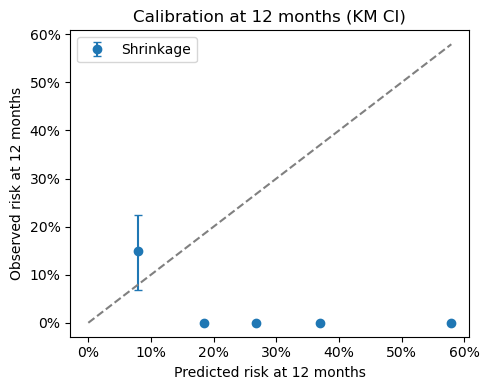

In [102]:
import matplotlib.pyplot as plt

def plot_calibration_with_ci(x, y, lo, hi, label):
    yerr = np.vstack([y - lo, hi - y])  # asymmetric errors
    plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=3, label=label)

plt.figure(figsize=(5,4))

# # ORIGINAL
# x_o, y_o, lo_o, hi_o, n_o = calibration_by_bin_with_ci(r_df, risk_orig, t0_months, n_bins=n_bins)
# plot_calibration_with_ci(x_o, y_o, lo_o, hi_o, "Original")

# SHRINKAGE
x_s, y_s, lo_s, hi_s, n_s = calibration_by_bin_with_ci(r_df, risk_shrunk, t0_months, n_bins=n_bins)
plot_calibration_with_ci(x_s, y_s, lo_s, hi_s, "Shrinkage")

# SHRINKAGE + BASELINE
# x_r, y_r, lo_r, hi_r, n_r = calibration_by_bin_with_ci(r_df, risk_recal, t0_months, n_bins=n_bins)
# plot_calibration_with_ci(x_r, y_r, lo_r, hi_r, "Shrinkage + baseline")

maxv = max(np.nanmax(x_s), np.nanmax(y_s))
plt.plot([0, maxv], [0, maxv], "--", color="grey")

plt.xlabel(f"Predicted risk at {t0_months} months")
plt.ylabel(f"Observed risk at {t0_months} months")
plt.title(f"Calibration at {t0_months} months (KM CI)")
# plt.xlim(0, 0.05)
# plt.ylim(0, 0.05)
plt.gca().xaxis.set_major_formatter(lambda x, pos: f"{100*x:.0f}%")
plt.gca().yaxis.set_major_formatter(lambda y, pos: f"{100*y:.0f}%")
plt.legend()
plt.tight_layout()
plt.show()


In [103]:
dat_set.Event.value_counts()

Event
0    240
1    156
Name: count, dtype: int64

In [104]:
t0 = t0_months

n_total = len(dat_set)
n_reached_24 = (dat_set["Disease_Duration"] >= t0).sum()

print(f"Total individuals: {n_total}")
print(f"Observed ≥ {t0} months: {n_reached_24}")
print(f"Proportion observed ≥ {t0} months: {n_reached_24 / n_total:.2f}")


Total individuals: 396
Observed ≥ 12 months: 384
Proportion observed ≥ 12 months: 0.97


In [105]:
import pandas as pd

df_bins = pd.DataFrame({"pred": risk_orig})
df_bins["bin"] = pd.qcut(df_bins["pred"], q=n_bins, duplicates="drop")

# Number of people per bin
bin_counts = df_bins["bin"].value_counts().sort_index()
print(bin_counts)

bin
(0.00666, 0.137]    80
(0.137, 0.229]      79
(0.229, 0.308]      79
(0.308, 0.439]      79
(0.439, 0.928]      79
Name: count, dtype: int64


### **Evaluate model on an external dataset**

In [112]:
# Step 1 — Prepare external dataset
ext_dataset = ril_3010.copy()
with localconverter(default_converter + pandas2ri.converter):
        r_ext_df = pandas2ri.py2rpy(ext_dataset)


# Step 2 — Generate predictions in the external data
# Compute the linear predictor (risk scale)
lp_surv_ext = predict_lp_stpm2(model_final, r_ext_df)
lp_risk_ext = -np.array(lp_surv_ext, dtype=float)
print(lp_risk_ext.shape)

# Apply shrinkage
lp_risk_ext_shrunk = lp_risk_ext * shrinkage

# Step 3 — Predict absolute risk at the horizon
# Survival from the original baseline: This is Model A (frozen baseline).
S_ext = predict_surv_stpm2_at_t0(model_final, r_ext_df, t0_months)
risk_ext_A = 1 - np.array(S_ext, dtype=float)

# Optional: baseline recalibration in the external data (Model B)
# Estimate external CITL (recommended)
citl_ext = citl_at_t0(model_final, r_ext_df, t0_months)
baseline_factor_ext = np.exp(-citl_ext)
risk_ext_B = 1 - np.power(S_ext, baseline_factor_ext)
print(risk_ext_B.shape)


# Step 4 — External discrimination (this comes first)
# C-index
from rpy2.robjects import FloatVector
r_ext_for_eval = ro.r("transform")(r_ext_df, predicted=FloatVector(lp_risk_ext_shrunk.tolist()))

cindex_ext = r_cindex(
    survival.concordance(
        ro.Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
        data=r_ext_for_eval
    )
)
print("External C-index (shrinkage applied):", cindex_ext)
# Interpretation:
# If C-index holds up → transportable ranking
# If it drops a lot → case-mix or predictor effect differences

# Step 5 — External calibration (this is the core)
# Calibration slope (external)
cal_ext = survival.coxph(
    ro.Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
    data=r_ext_for_eval
)
slope_ext = float(ro.r['coef'](cal_ext)[0])
print("External calibration slope (shrinkage applied):", slope_ext)
# Interpretation:
# If slope ≈ 1 → predictor effects transport well
# If slope < 1 → predictor effects too strong; overfitting in development
# If slope > 1 → predictor effects too weak; underfitting in development

# Calibration-in-the-large (external)
# At the horizon:
citl_ext = citl_at_t0(model_final, r_ext_df, t0_months)
print(f"External CITL at {t0_months} months:", citl_ext)
# Interpretation:
# If CITL ≈ 0 → baseline risk transport well
# If CITL < 0 → baseline risk too high in development (common)
# If CITL > 0 → baseline risk too low in development (common)

# External calibration plot



(957,)
(957,)
External C-index (shrinkage applied): 0.14031548728481547
External calibration slope (shrinkage applied): 1.4174483682141241
External CITL at 12 months: 1.960979664090693


In [107]:
t0_months

12

### *Fit a flexible parametric survival model (baseline model) -  The baseline log-cumulative-hazard* 

In [ ]:
with conversion.localconverter(pandas2ri.converter):
    r_miroli0 = pandas2ri.py2rpy(miroli0)

with conversion.localconverter(pandas2ri.converter):
    r_ril_3010 = pandas2ri.py2rpy(ril_3010)

with conversion.localconverter(pandas2ri.converter):
    r_proact0 = pandas2ri.py2rpy(proact0)

In [ ]:
# Define the formula
formula = Formula('Surv(Disease_Duration, Event==1) ~ Age + TRICALS + Diagnostic_Delay + Vital_capacity + Onset_Limb + Sex_Male + Sex_onset')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model = rstpm2.stpm2(formula, data=r_miroli0, df=0)
# print(ro.r.summary(fp_model))

In [ ]:
def predict_lp_stpm2(model, newdata):
    """
    Compute linear predictor Xβ for stpm2 model
    """
    X = ro.r['predict'](model, newdata=newdata, type="lpmatrix")
    beta = ro.r['coef'](model)
    return ro.r['as.numeric'](X @ beta)


In [ ]:
predictions_full = predict_lp_stpm2(fp_model, r_miroli0)
predictions_full

In [ ]:
# # Define the formula
# formula = Formula('Surv(Disease_Duration, Event==1) ~ Age  + Sex_Male + Onset_Limb + TRICALS + Diagnostic_Delay + Study_Arm_Placebo')

# # Fit the flexible parametric model
# # df = degrees of freedom for spline, adjust as needed
# fp_model = rstpm2.stpm2(formula, data=r_train_df, df=0)
# # print(ro.r.summary(fp_model))

In [ ]:
df_coef = extract_coefficients_from_fp_model_log_haz_scale(fp_model)
df_coef = round(df_coef, 4)
df_coef

In [ ]:
df_coef = extract_coefficients_from_fp_model_haz_scale(fp_model)
df_coef = round(df_coef, 4)
df_coef

In [ ]:
forest_plot_fp_model_haz_scale(extract_coefficients_from_fp_model_haz_scale(fp_model))

In [ ]:
# train_df.columns = train_df.columns.str.replace(' ', '_')
# test_df.columns = test_df.columns.str.replace(' ', '_')
ril_3010.columns

In [ ]:
means = ["Age", "TRICALS", "Diagnostic_Delay"]
modes = ["Sex_Male", "Onset_Limb", "Sex_onset",'Study_Arm_Placebo']

In [ ]:
# Prepare newdata for train and test
times_train = np.linspace(0, train_df["Disease_Duration"].max(), 100)
newdata_train = make_newdata_for_fp_model_prediction(train_df, times_train, means, modes, 'Disease_Duration')

times_test = np.linspace(0, test_df["Disease_Duration"].max(), 100)
newdata_test = make_newdata_for_fp_model_prediction(test_df, times_test, means, modes, 'Disease_Duration')

times_miroli0 = np.linspace(0, miroli0["Disease_Duration"].max(), 100)
newdata_miroli0 = make_newdata_for_fp_model_prediction(miroli0, times_miroli0, means, modes, 'Disease_Duration')

times_ril_3010 = np.linspace(0, ril_3010["Disease_Duration"].max(), 100)
newdata_ril_3010 = make_newdata_for_fp_model_prediction(ril_3010, times_ril_3010, means, modes, 'Disease_Duration')

times_proact0 = np.linspace(0, proact0["Disease_Duration"].max(), 100)
newdata_proact0 = make_newdata_for_fp_model_prediction(proact0, times_proact0, means, modes, 'Disease_Duration')

So while you can generate predictions at 50 months, you cannot validate them.

Prediction may be possible. Validation is not.


If you pretend the second trial has 50 months of follow-up:

You create informative censoring

You inflate uncertainty

You risk misleading conclusions about long-term survival

You can say:

“The model was trained on a 50-month trial and externally validated on an independent 22-month trial. Model performance was assessed at clinically relevant time points up to 22 months.”

In [ ]:
# ril_3010['Disease_Duration'].describe()
# miroli0['Disease_Duration'].describe()
# proact0['Disease_Duration'].describe()

In [ ]:
newdata_miroli0
newdata_ril_3010
# newdata_train

In [ ]:
# import inspect
# inspect.signature(prediction_survival_for_average_patient_fp_model_train_test)

In [ ]:
prediction_survival_for_average_patient_fp_model_train_test(train_df,
                                                            test_df,
                                                            ril_3010,
                                                            fp_model,
                                                            newdata_train=newdata_train,
                                                            newdata_test=newdata_test,
                                                            newdata_valid=newdata_ril_3010,
                                                            time_col='Disease_Duration',
                                                            title_suffix="title_suffix",
                                                            Train_set='Train_set',
                                                            Test_set='Test_set',
                                                            Validation_set='Validation_set')

In [ ]:
newdata_0_train, newdata_1_train = make_newdata_category_for_fp_model_prediction(train_df, means, modes, time_col="Disease_Duration", cat_col='Study_Arm_Placebo')
newdata_0_test, newdata_1_test = make_newdata_category_for_fp_model_prediction(test_df, means, modes, time_col="Disease_Duration", cat_col='Study_Arm_Placebo')
newdata_0_valid, newdata_1_valid = make_newdata_category_for_fp_model_prediction(ril_3010, means, modes, time_col="Disease_Duration", cat_col='Study_Arm_Placebo')

In [ ]:
prediction_survival_for_average_patient_cat_cov_fp_model_train_test(df_train=train_df,
                                                                    df_test=test_df,
                                                                    df_valid=ril_3010,
                                                                    fp_model=fp_model,
                                                                    newdata_0_train=newdata_0_train,
                                                                    newdata_1_train=newdata_1_train,
                                                                    newdata_0_test=newdata_0_test,
                                                                    newdata_1_test=newdata_1_test,
                                                                    newdata_0_valid=newdata_0_valid,
                                                                    newdata_1_valid=newdata_1_valid,
                                                                    time_col="Disease_Duration",
                                                                    title_suffix="",
                                                                    Train_set="",
                                                                    Test_set="",
                                                                    Validation_set=""
                                                                )

In [ ]:
prediction_hazard_for_average_patient_fp_model_train_test(
    train_df,
    test_df,
    ril_3010,
    fp_model,
    newdata_train=newdata_train,
    newdata_test=newdata_test,
    newdata_valid=newdata_ril_3010,
    time_col='Disease_Duration',
    title_suffix="title_suffix",
    Train_set='Train_set',
    Test_set='Test_set',
    Validation_set='Validation_set')

In [ ]:
prediction_hazard_for_average_patient_cat_cov_fp_model_train_test(df_train=train_df,
                                                                    df_test=test_df,
                                                                    df_valid=ril_3010,
                                                                    fp_model=fp_model,
                                                                    newdata_0_train=newdata_0_train,
                                                                    newdata_1_train=newdata_1_train,
                                                                    newdata_0_test=newdata_0_test,
                                                                    newdata_1_test=newdata_1_test,
                                                                    newdata_0_valid=newdata_0_valid,
                                                                    newdata_1_valid=newdata_1_valid,
                                                                    time_col="Disease_Duration",
                                                                    title_suffix="",
                                                                    Train_set="",
                                                                    Test_set="",
                                                                    Validation_set=""
                                                                )

## Prognostic Scores for Baseline Model (fit)

In [ ]:
train_df = prognostic_score(train_df, fp_model, groups=3)
train_df.head(3)

In [ ]:
train_df['risk_group'] = pd.qcut(train_df['prognostic_score'], 3, labels=['Low','Medium','High'])

train_df.head(6)
train_df.risk_group.value_counts().to_dict()

In [ ]:
for group in ['Low','Medium','High']:
    subset = train_df[train_df['risk_group']==group]
    kmf = KaplanMeierFitter()
    kmf.fit(subset['Disease_Duration'], subset['Event'], label=group)
    kmf.plot_survival_function()
plt.title("K–M - Prognostic Score")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend(title="Risk Group")
plt.grid(True)
plt.show()

## ***Simulate Virtual Placebo***

In [ ]:
train_df.info()

In [ ]:
cols = ['subject_id']

for col in (train_df.select_dtypes(include=['object', 'category', 'int']).columns):
    if col not in cols:
        print(f"{train_df[col].value_counts() / train_df[col].value_counts().sum()}\n")

In [ ]:
ons = train_df['Onset_Limb'].value_counts() / train_df['Onset_Limb'].value_counts().sum()
sex = train_df['Sex_Male'].value_counts() / train_df['Sex_Male'].value_counts().sum()
pla = train_df['Study_Arm_Placebo'].value_counts() / train_df['Study_Arm_Placebo'].value_counts().sum()
# exp = train_df['Expt_mirocals'].value_counts() / train_df['Expt_mirocals'].value_counts().sum()
# eur = train_df['European_Yes'].value_counts() / train_df['European_Yes'].value_counts().sum()


In [ ]:
ons, sex

In [ ]:
train_df.head(3)

In [ ]:
train_df.columns

In [ ]:
train_df.head(3)

In [ ]:
corr = train_df[['Age','Study_Arm_Placebo','Diagnostic_Delay','Vital_capacity','Sex_Male', 
            	 'Onset_Limb','TRICALS']].corr()
corr

In [ ]:
df = df_coef.copy()
df

In [ ]:
# df.loc[df["Variable"] == "Age", "Estimate"].values[0]
# ons
# sex[1]
# pla[1]

In [ ]:
var_specs_real = [
    # continuous
    {'name':'Age','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':df.loc[df["Variable"] == "Age", "Estimate"].values[0]},
    {'name':'TRICALS','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':df.loc[df["Variable"] == "TRICALS", "Estimate"].values[0]},
    {'name':'Diagnostic_Delay','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},
                                                           'coef':df.loc[df["Variable"] == "Diagnostic_Delay", "Estimate"].values[0]},
    # {'name':'Vital_capacity','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},
    #                                                        'coef':df.loc[df["Variable"] == "Vital capacity", "Estimate"].values[0]},

    # binary
    {'name':'Sex_Male','type':'binary','prob':sex[1],'coef':df.loc[df["Variable"] == "Sex_Male", "Estimate"].values[0]},
    {'name':'Onset_Limb','type':'binary','prob':ons[1],'coef':df.loc[df["Variable"] == "Onset_Limb", "Estimate"].values[0]},
    # {'name':'Expt_mirocals','type':'binary','prob':exp[1],'coef':df.loc[df["Variable"] == "Expt_mirocals", "Estimate"].values[0]},
    {'name':'Study_Arm_Placebo','type':'binary','prob':pla[1],'coef':df.loc[df["Variable"] == "Study_Arm_Placebo", "Estimate"].values[0]},

    # # categorical
    # {'name':'Onset_site','type':'categorical',
    #  'levels':['bulbar','limb','other'],'probs':[0.218484,0.746833,0.034683],
    #  'coef':{'limb':1.151159,'other':2.508786},'ref':'bulbar'}
]

corr = train_df[['Age', 'TRICALS', 'Diagnostic_Delay','Sex_Male', 'Onset_Limb', 'Study_Arm_Placebo']].corr()

# df_sim = simulate_cox_dataset(n=df1.shape[0], baseline='weibull', lam=0.01, rho=1.5, 
#                               censor_rate=0.3, seed=42, corr=corr, var_specs=var_specs_real)


# df_sim.head(3)

In [ ]:
train_df.Event.value_counts() / train_df.Event.value_counts().sum()

In [ ]:
H0_df = estimate_baseline_cumhaz(train_df, time_col='Disease_Duration', event_col='Event')
# H0_df

In [ ]:
# Real dataset
# H0_df = estimate_baseline_cumhaz(real_df)

# Simulated dataset
sim_df = simulate_cox_dataset_with_correlation(
    # n=500,
    n=train_df.shape[0],
    var_specs=var_specs_real,
    corr=corr,
    baseline="empirical",
    H0_df=H0_df,
    censor_rate=0.4,
    seed=42
)


In [ ]:
sim_df.head(3)

In [ ]:
# Create interactions
sim_df['Sex_onset'] = sim_df['Sex_Male']*sim_df['Onset_Limb']
sim_df.head(3)

In [ ]:
sim_df.event.value_counts() #/ sim_df.event.value_counts().sum()

In [ ]:
train_df.head(3)

In [ ]:
train_df.Event.value_counts() #/ train_df.event.value_counts().sum()

In [ ]:
ons = train_df['Onset_Limb'].value_counts() / train_df['Onset_Limb'].value_counts().sum()
sex = train_df['Sex_Male'].value_counts() / train_df['Sex_Male'].value_counts().sum()
sex_ons = train_df['Sex_onset'].value_counts() / train_df['Sex_onset'].value_counts().sum()
print(ons, sex, sex_ons)

print("\n---- Simulated data ----")
ons1 = sim_df['Onset_Limb'].value_counts() / sim_df['Onset_Limb'].value_counts().sum()
sex1 = sim_df['Sex_Male'].value_counts() / sim_df['Sex_Male'].value_counts().sum()
sex_ons1 = sim_df['Sex_onset'].value_counts() / sim_df['Sex_onset'].value_counts().sum()

print(ons1, sex1, sex_ons1)

In [ ]:
with conversion.localconverter(pandas2ri.converter):
    r_df_sim = pandas2ri.py2rpy(sim_df)

In [ ]:
# # Define the formula
formula1 = Formula('Surv(true_survival_time, event==1) ~ Age + Study_Arm_Placebo + Onset_Limb + TRICALS + Sex_Male + Diagnostic_Delay')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model1 = rstpm2.stpm2(formula1, data=r_df_sim, df=0)
# print(ro.r.summary(fp_model1))

In [ ]:
df_coef1 = extract_coefficients_from_fp_model_haz_scale(fp_model1)
df_coef1

In [ ]:
df_coef

In [ ]:
coefs = pd.merge(df_coef, df_coef1, on="Variable", suffixes=('_real', '_simulated'))
coefs = round(coefs, 4)
coefs

In [ ]:
coefs1 = coefs[['Variable', 'Estimate_real', 'Estimate_simulated']]
coefs1

In [ ]:
x = np.arange(len(coefs1))      # positions
width = 0.35                # bar width

plt.figure(figsize=(8, 4))

# Bars
plt.bar(x - width/2, coefs1["Estimate_real"], width, label="Original Data")
plt.bar(x + width/2, coefs1["Estimate_simulated"], width, label="Simulated Data")

# Zero line
plt.axhline(0, linestyle="--", linewidth=1)

# Labels
plt.xticks(x, coefs1["Variable"], rotation=45, ha="right")
plt.ylabel("Coefficient value")
plt.title("Bar Plot of Coefficients: Original vs Simulated Data")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
coefs1 = coefs[['Variable', 'HR_real', 'HR_simulated']]
coefs1

x = np.arange(len(coefs1))      # positions
width = 0.35                # bar width

plt.figure(figsize=(8, 4))

# Bars
plt.bar(x - width/2, coefs1["HR_real"], width, label="Original Data")
plt.bar(x + width/2, coefs1["HR_simulated"], width, label="Simulated Data")

# Zero line
plt.axhline(0, linestyle="--", linewidth=1)

# Labels
plt.xticks(x, coefs1["Variable"], rotation=45, ha="right")
plt.ylabel("Coefficient value")
plt.title("Bar Plot of Coefficients: Original vs Simulated Data")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
for col in ['Age', 'TRICALS', 'Diagnostic_Delay']:  # replace with your continuous columns
    plt.figure(figsize=(5,4))
    plt.hist(train_df[col], bins=30, alpha=0.5, label='Original', density=True)
    plt.hist(sim_df[col], bins=30, alpha=0.5, label='Simulated', density=True)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()

In [ ]:
cols = ['Age', 'TRICALS', 'Diagnostic_Delay']

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Original correlation
sns.heatmap(train_df[cols].corr(), annot=True, cmap="coolwarm", ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("Original Correlation Matrix")

# Simulated correlation
sns.heatmap(sim_df[cols].corr(), annot=True, cmap="coolwarm", ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title("Simulated Correlation Matrix")

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import ttest_ind

cols = ['Age', 'TRICALS', 'Diagnostic_Delay']

results = []

for col in cols:
    original = train_df[col].dropna()
    simulated = sim_df[col].dropna()

    # Welch t-test
    t_stat, p_val = ttest_ind(original, simulated, equal_var=False)

    # Mean difference
    mean_diff = simulated.mean() - original.mean()

    # Standard errors for CI (Welch)
    se = np.sqrt(original.var()/len(original) + simulated.var()/len(simulated))

    # 95% CI
    ci_low = mean_diff - 1.96 * se
    ci_high = mean_diff + 1.96 * se

    results.append([col, mean_diff, ci_low, ci_high, p_val])

df_plot = pd.DataFrame(results, columns=["Variable", "MeanDiff", "CI_low", "CI_high", "p_value"])


# --------- Forest Plot ---------
plt.figure(figsize=(8, 6))

y_pos = np.arange(len(df_plot))

plt.errorbar(
    df_plot["MeanDiff"], 
    y_pos, 
    xerr=[df_plot["MeanDiff"] - df_plot["CI_low"], df_plot["CI_high"] - df_plot["MeanDiff"]],
    fmt='o', 
    capsize=5
)

plt.axvline(0, color='gray', linestyle='--')

plt.yticks(y_pos, df_plot["Variable"])
plt.xlabel("Mean Difference (Simulated − Original)")
plt.title("Forest Plot of T-Test Mean Differences")

plt.tight_layout()
plt.show()

In [ ]:
# remove the interaction term from the model